In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/h2o-train-test/train.csv
/kaggle/input/h2o-train-test/test.csv
/kaggle/input/h2o-train-test-aqi-calc/test_df_after_aqi_calc.csv
/kaggle/input/h2o-train-test-aqi-calc/train_df_after_aqi_calc.csv
/kaggle/input/h2o-private-dataset/test_after_outlier_removal_standardized.csv
/kaggle/input/h2o-private-dataset/train_after_outlier_removal_standardized.csv
/kaggle/input/h2o-private-dataset/test_after_outlier_removal_scaled.csv
/kaggle/input/h2o-private-dataset/train_after_outlier_removal_scaled.csv
/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/sample_submission.csv
/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/train.csv
/kaggle/input/h2o-train-test-corrected/new_train_after_outlier_removal_standardized.csv
/kaggle/input/h2o-train-test-corrected/new_train_after_outlier_removal_scaled.csv
/kaggle/input/h2o-train-test-corrected/new_test_after_outlier_removal_standardized.csv
/kaggle/input/h2o-train-test-corrected/new_test_after_outlier_removal.csv
/kaggle/input

# AutoML on Data without AQI calculated columns 

In [8]:
train_df = pd.read_csv('/kaggle/input/h2o-train-test-corrected/new_train_after_outlier_removal.csv', parse_dates=["Date"])
display(train_df.head().style.set_caption('Train data'))

test_df = pd.read_csv('/kaggle/input/h2o-train-test-corrected/new_test_after_outlier_removal.csv', parse_dates=["Date"])
display(test_df.head().style.set_caption('Test data'))

In [9]:
train_df

StateCode       Date    PM2.5      PM10       O3       CO        SO2  \
0            AS 2021-08-17  51.8364  120.3702  18.0234  0.48960  14.310600   
1            AS 2021-08-18  59.4762   87.0978  34.5270  0.47940  14.759400   
2            AS 2021-08-19  61.0776   79.6008  42.0546  0.52020  16.748400   
3            AS 2021-08-20  56.7222   94.2072  45.7878  0.49980  23.342738   
4            AS 2021-08-21  85.3332  136.7820  44.5638  1.11180  23.342738   
...         ...        ...      ...       ...      ...      ...        ...   
25818        WB 2022-11-29  16.3275   33.8940  36.5190  0.65100   3.549000   
25819        WB 2022-11-30  15.2880   29.9145  37.2225  0.63525   2.940000   
25820        WB 2022-12-01  14.1015   31.1325  27.1845  0.67200   5.428500   
25821        WB 2022-12-02  17.8605   30.5340  30.0510  0.59850   7.423500   
25822        WB 2022-12-03  16.6215   28.8750  37.2120  0.66150  11.319000   

         AQI  DayOfWeek  DayOfMonth  WeekOfYear  Month  DayOfYear  ID  
0       94.0          1          17          33      8        229   0  
1      124.0          2          18          33      8        230   0  
2       82.0          3          19          33      8        231   0  
3      107.0          4          20          33      8        232   0  
4      107.0          5          21          33      8        233   0  
...      ...        ...         ...         ...    ...        ...  ..  
25818   47.0          1          29          48     11        333  39  
25819   52.0          2          30          48     11        334  39  
25820   41.0          3           1          48     12        335  39  
25821   40.0          4           2          48     12        336  39  
25822   48.0          5           3          48     12        337  39  

[25823 rows x 14 columns]

Train Valid Split

In [10]:
train = pd.DataFrame(columns = train_df.columns)  
valid = pd.DataFrame(columns = train_df.columns)  


for station in train_df['ID'].unique():
    print('NEW LOCATION -',station)
    location_train_df = train_df[train_df["ID"] == station]
    
    index = (80 * len(location_train_df['AQI'].values))//100
    
    t =  location_train_df.iloc[:index]
    v = location_train_df.iloc[index:]
    
    train = train.append(t)
    valid = valid.append(v)    

NEW LOCATION - 0
NEW LOCATION - 1
NEW LOCATION - 2
NEW LOCATION - 3
NEW LOCATION - 4
NEW LOCATION - 5
NEW LOCATION - 6
NEW LOCATION - 7
NEW LOCATION - 8
NEW LOCATION - 9
NEW LOCATION - 10
NEW LOCATION - 11
NEW LOCATION - 12
NEW LOCATION - 13
NEW LOCATION - 14
NEW LOCATION - 15
NEW LOCATION - 16
NEW LOCATION - 17
NEW LOCATION - 18
NEW LOCATION - 19
NEW LOCATION - 20
NEW LOCATION - 21
NEW LOCATION - 22
NEW LOCATION - 23
NEW LOCATION - 24
NEW LOCATION - 25
NEW LOCATION - 26
NEW LOCATION - 27
NEW LOCATION - 28
NEW LOCATION - 29
NEW LOCATION - 30
NEW LOCATION - 31
NEW LOCATION - 32
NEW LOCATION - 33
NEW LOCATION - 34
NEW LOCATION - 35
NEW LOCATION - 36
NEW LOCATION - 37
NEW LOCATION - 38
NEW LOCATION - 39


In [11]:
train.shape,valid.shape,test_df.shape

((20648, 14), (5175, 14), (1120, 14))

# Custom metric

In [12]:
from sklearn.metrics import make_scorer
import numpy as np

def mmae(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    mask = y_true > y_pred
    return np.average(np.where(mask, 1.5 * diff, diff))

mmae_scorer = make_scorer(mmae, greater_is_better=False)

In [13]:
from __future__ import print_function
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.18" 2023-01-17; OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppu21v3ud
  JVM stdout: /tmp/tmppu21v3ud/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppu21v3ud/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.2
H2O_cluster_version_age:    1 month and 7 days
H2O_cluster_name:           H2O_from_python_unknownUser_flj5d3
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.500 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ----------------------------------

In [14]:
hf_train = h2o.H2OFrame(train)
hf_valid = h2o.H2OFrame(valid)
hf_test = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# Identify predictors and response
X = hf_train.columns
y = "AQI"
X.remove(y)

In [16]:
# Identify predictors and response
X_val = hf_valid.columns
y_val = "AQI"
X_val.remove(y_val)

In [34]:
import h2o
from h2o.automl import H2OAutoML

aml = H2OAutoML(seed = 42,   nfolds = 0,
         sort_metric = 'MAE',verbosity = 'info',keep_cross_validation_predictions = True,
max_runtime_secs=1200)

aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          validation_frame = hf_valid,
          leaderboard_frame = hf_valid)

AutoML progress: |
09:40:57.401: Project: AutoML_2_20230417_94057
09:40:57.401: Cross-validation disabled by user: no fold column nor nfolds > 1.
09:40:57.401: Setting stopping tolerance adaptively based on the training frame: 0.006959227023125169
09:40:57.401: Build control seed: 42
09:40:57.402: training frame: Frame key: AutoML_2_20230417_94057_training_Key_Frame__upload_9050b1a9425cf62b4c7113f59eb14cd2.hex    cols: 14    rows: 20648  chunks: 1    size: 1323252  checksum: 935770363065556981
09:40:57.402: validation frame: Frame key: Key_Frame__upload_9f24b07f33ee7db9c0eb57461fb6490e.hex    cols: 14    rows: 5175  chunks: 1    size: 327821  checksum: -245469713389312792
09:40:57.402: leaderboard frame: Frame key: Key_Frame__upload_9f24b07f33ee7db9c0eb57461fb6490e.hex    cols: 14    rows: 5175  chunks: 1    size: 327821  checksum: -245469713389312792
09:40:57.402: blending frame: NULL
09:40:57.402: response column: AQI
09:40:57.402: fold column: null
09:40:57.402: weights column: null

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_2_20230417_94057_model_174


Model Summary: 
    number_of_trees
--  -----------------
    65

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 349.61929120303074
RMSE: 18.698109294873394
MAE: 12.638596297788418
RMSLE: 0.11940748230701721
Mean Residual Deviance: 349.61929120303074

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 779.5050060133109
RMSE: 27.91961686723711
MAE: 20.06124272701245
RMSLE: 0.1972403741639731
Mean Residual Deviance: 779.5050060133109

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-04-17 09:48:06  6 min 20.134 sec  0                  232.853          194.65          54220.7              205.635            169.994           42285.9
    2023-04-17 09:48:07  6 min 20.254 sec  5                  57.9644          39.6484         3359.87              50.6408            35.2064           2564.49
    2023-04-17 09:48:07  6 min 20.434 sec  10                 33.3838          21.5234         1114.48              31.2911            21.9626           979.131
    2023-04-17 09:48:07  6 min 20.638 sec  15                 28.5842          18.8261         817.058              28.9628            20.6176           838.845
    2023-04-17 09:48:07  6 min 20.841 sec  20                 26.491           17.6574         701.772              28.6087            20.5034           818.458
    2023-04-17 09:48:07  6 min 21.056 sec  25                 24.9125          16.6393         620.63               28.3676            20.2984           804.723
    2023-04-17 09:48:08  6 min 21.310 sec  30                 23.5991          15.7734         556.917              28.272             20.1858           799.304
    2023-04-17 09:48:08  6 min 21.577 sec  35                 22.5136          15.0751         506.864              28.2178            20.1063           796.245
    2023-04-17 09:48:08  6 min 21.880 sec  40                 21.7852          14.6426         474.595              28.0729            20.0288           788.087
    2023-04-17 09:48:08  6 min 22.183 sec  45                 21.0514          14.1685         443.161              27.9992            19.9854           783.957
    2023-04-17 09:48:09  6 min 22.485 sec  50                 20.5654          13.8662         422.934              27.9293            19.9612           780.045
    2023-04-17 09:48:09  6 min 22.818 sec  55                 19.9677          13.4771         398.708              27.9306            20.0048           780.116
    2023-04-17 09:48:09  6 min 23.174 sec  60                 19.2938          13.0431         372.251              28.005             20.073            784.281
    2023-04-17 09:48:10  6 min 23.553 sec  65                 18.6981          12.6386         349.619              27.9196            20.0612           779.505

Variable Importances: 
variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ------------
PM2.5         2.7946e+08             1                    0.601366
PM10          1.58114e+08            0.565783             0.340243
CO            5.46447e+06            0.0195537            0.0117589
O3            4.33623e+06            0.0155164            0.00933107
Date          3.24373e+06            0.0116071            0.00698014
DayOfYear     2.91078e+06            0.0104157            0.00626367
DayOfMonth    2.59040e+06            0.00926932           0.00557426
WeekOfYear    2.52615e+06            0.00903941           0.005436
DayOfWeek     1.78627e+06            0.00639185           0.00384384
ID

In [35]:
lb = aml.leaderboard
lb

model_id                                              mae     rmse      mse     rmsle    mean_residual_deviance
------------------------------------------------  -------  -------  -------  --------  ------------------------
XGBoost_grid_1_AutoML_2_20230417_94057_model_174  20.0612  27.9196  779.505  0.19724                    779.505
XGBoost_grid_1_AutoML_2_20230417_94057_model_167  20.0671  27.6204  762.885  0.197789                   762.885
XGBoost_grid_1_AutoML_2_20230417_94057_model_190  20.2553  27.7641  770.845  0.195466                   770.845
XGBoost_grid_1_AutoML_2_20230417_94057_model_156  20.4221  28.417   807.528  0.199626                   807.528
XGBoost_grid_1_AutoML_2_20230417_94057_model_96   20.5515  28.0873  788.895  0.200927                   788.895
XGBoost_grid_1_AutoML_2_20230417_94057_model_20   20.5736  28.2698  799.181  0.20104                    799.181
XGBoost_grid_1_AutoML_2_20230417_94057_model_163  20.819   28.7784  828.195  0.200761                   828.195
XGBoost_grid_1_AutoML_2_20230417_94057_model_14   20.9659  28.5621  815.793  0.20163                    815.793
XGBoost_grid_1_AutoML_2_20230417_94057_model_6    21.1003  28.5674  816.095  0.205301                   816.095
XGBoost_grid_1_AutoML_2_20230417_94057_model_213  21.1329  28.8669  833.3    0.202952                   833.3
[351 rows x 6 columns]

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                   rmse       mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  -------  --------  -------  --------  ------------------------  ------------------  -------------------------  ---------------
StackedEnsemble_BestOfFamily_4_AutoML_1_20230417_90853  28.5823   816.945  21.192   0.206414                   816.945                6076                   0.115801  StackedEnsemble
GBM_grid_1_AutoML_1_20230417_90853_model_6              29.6256   877.678  22.2887  0.219724                   877.678                1111                   0.013181  GBM
GBM_grid_1_AutoML_1_20230417_90853_model_1              29.7212   883.353  21.7622  0.214108                   883.353                2900                   0.038344  GBM
GBM_3_AutoML_1_20230417_90853                           30.0772   904.636  22.4911  0.21926                    904.636                4430                   0.075453  GBM
StackedEnsemble_BestOfFamily_2_AutoML_1_20230417_90853  30.1075   906.46   22.6015  0.219249                   906.46                 3990                   0.088935  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20230417_90853     30.1253   907.536  22.6333  0.220413                   907.536                7489                   0.352223  StackedEnsemble
XRT_1_AutoML_1_20230417_90853                           30.1774   910.678  22.9408  0.224791                   910.678                8432                   0.032818  DRF
StackedEnsemble_AllModels_2_AutoML_1_20230417_90853     30.1831   911.019  22.5658  0.218724                   911.019                7431                   0.421865  StackedEnsemble
DeepLearning_1_AutoML_1_20230417_90853                  30.3589   921.661  22.756   0.224425                   921.661                1479                   0.003421  DeepLearning
StackedEnsemble_BestOfFamily_3_AutoML_1_20230417_90853  30.36     921.728  22.5934  0.218792                   921.728                5378                   0.076752  StackedEnsemble
XGBoost_grid_1_AutoML_1_20230417_90853_model_4          30.5797   935.121  23.0061  0.220617                   935.121                7012                   0.008968  XGBoost
GBM_1_AutoML_1_20230417_90853                           30.7786   947.325  22.735   0.220181                   947.325                6843                   0.089979  GBM
GBM_4_AutoML_1_20230417_90853                           30.7968   948.442  23.1541  0.227289                   948.442                4190                   0.056358  GBM
GBM_5_AutoML_1_20230417_90853                           30.9501   957.911  22.9596  0.219996                   957.911                4508                   0.064342  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20230417_90853  30.9748   959.437  23.0521  0.224375                   959.437                4881                   0.108383  StackedEnsemble
DRF_1_AutoML_1_20230417_90853                           31.0124   961.768  23.7217  0.235656                   961.768                7593                   0.033864  DRF
GBM_grid_1_AutoML_1_20230417_90853_model_2              31.0801   965.974  22.7736  0.223573                   965.974                4421                   0.039424  GBM
GBM_2_AutoML_1_20230417_90853                           31.1202   968.467  23.3733  0.225746                   968.467                3997                   0.060744  GBM
StackedEnsemble_AllModels_3_AutoML_1_20230417_90853     31.495    991.935  23.9165  0.232057                   991.935               12955                   0.205698  StackedEnsemble
GBM_grid_1_AutoML_1_20230417_90853_model_5              31.6389  1001.02   23.689   0.228733                  1001.02                 4000                   0.058212  GBM
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

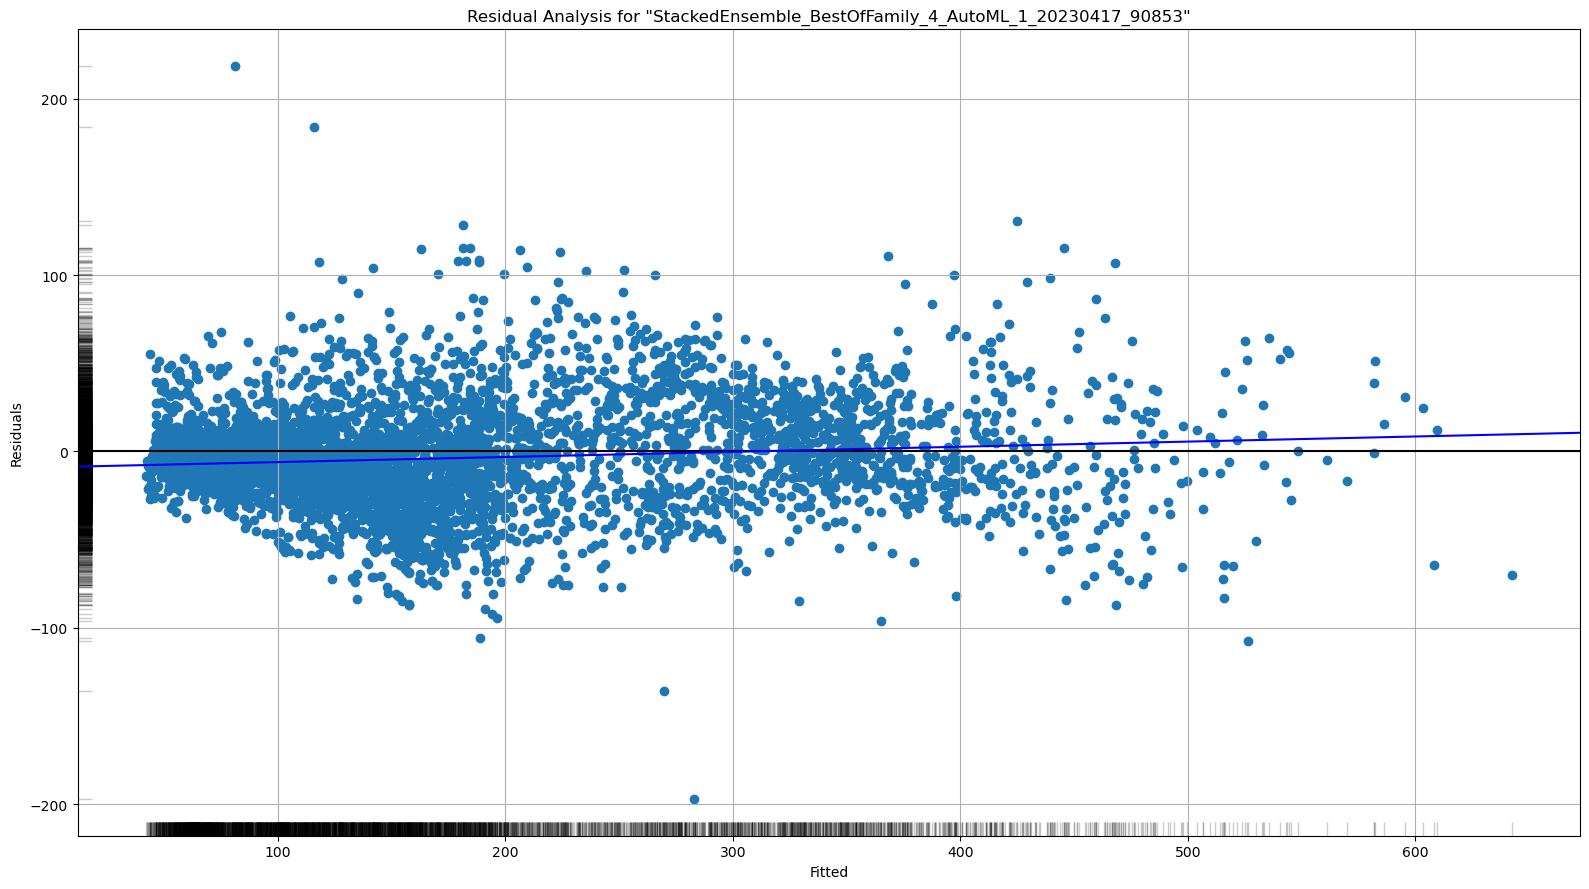

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

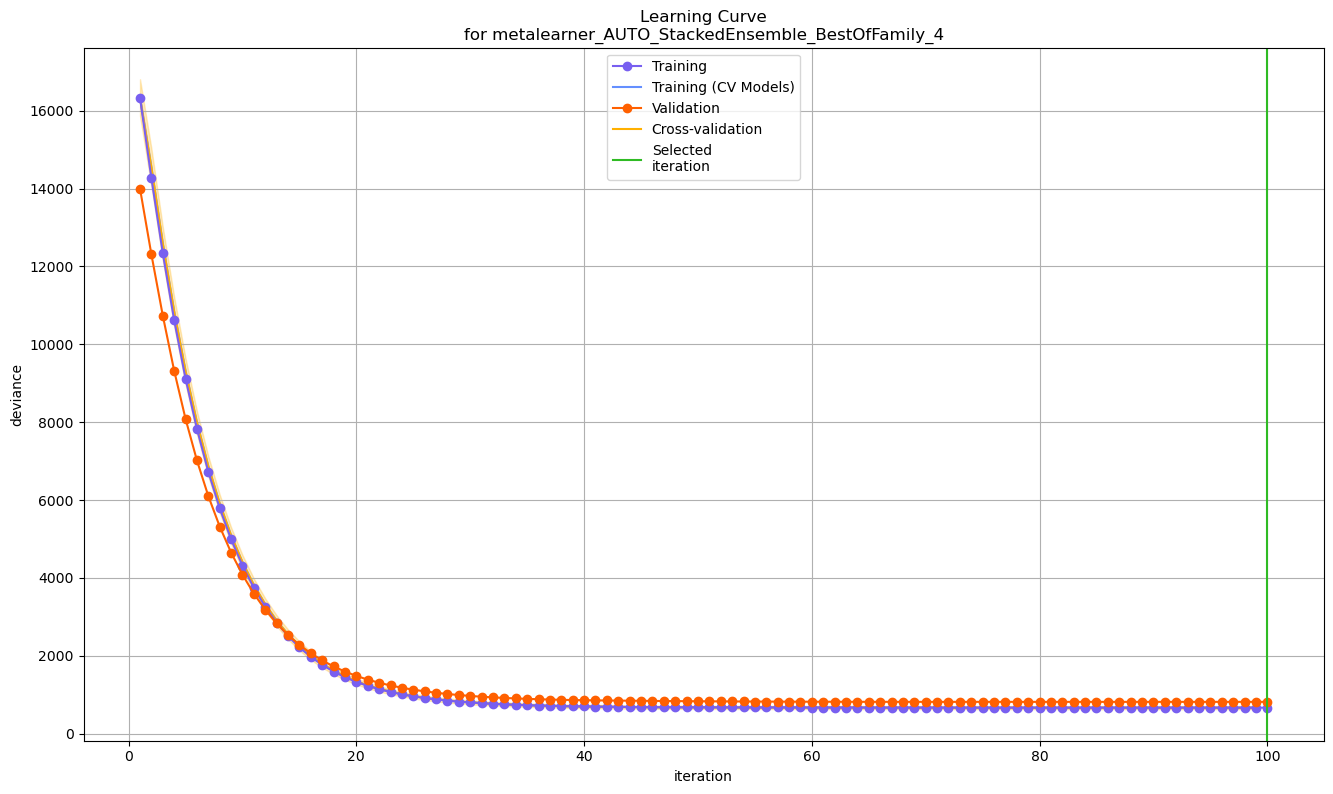

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

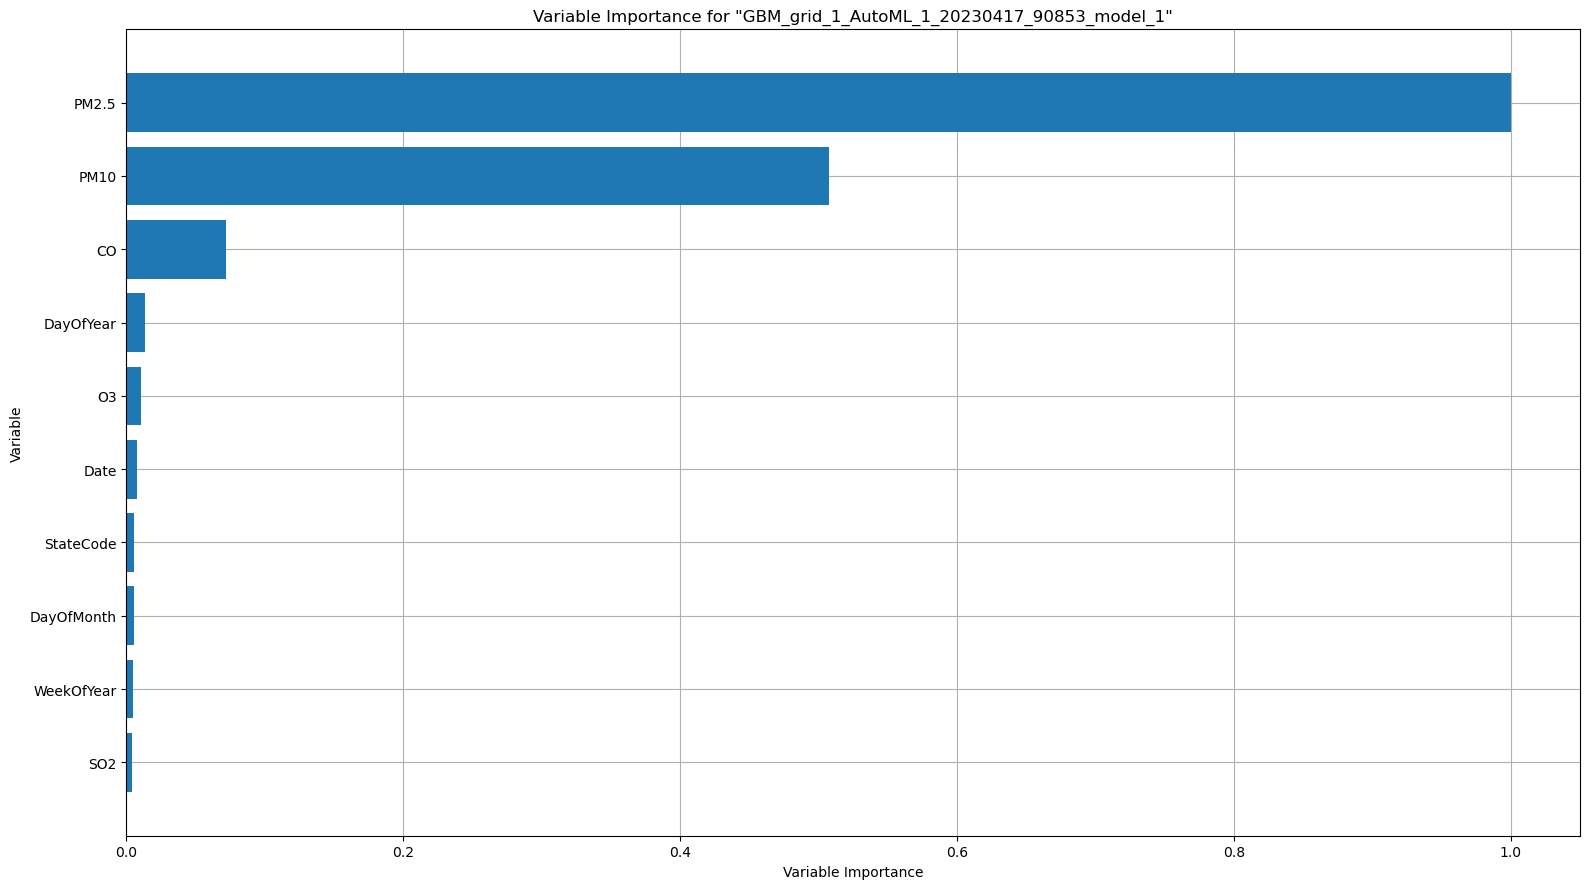

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

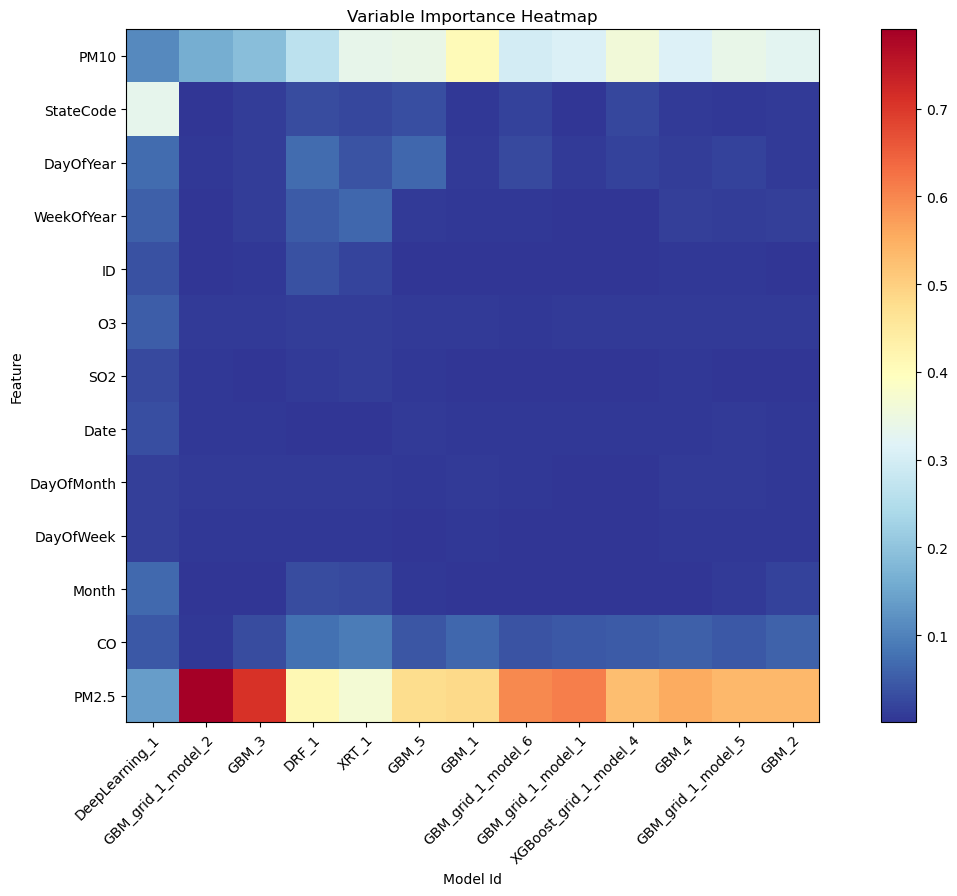

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

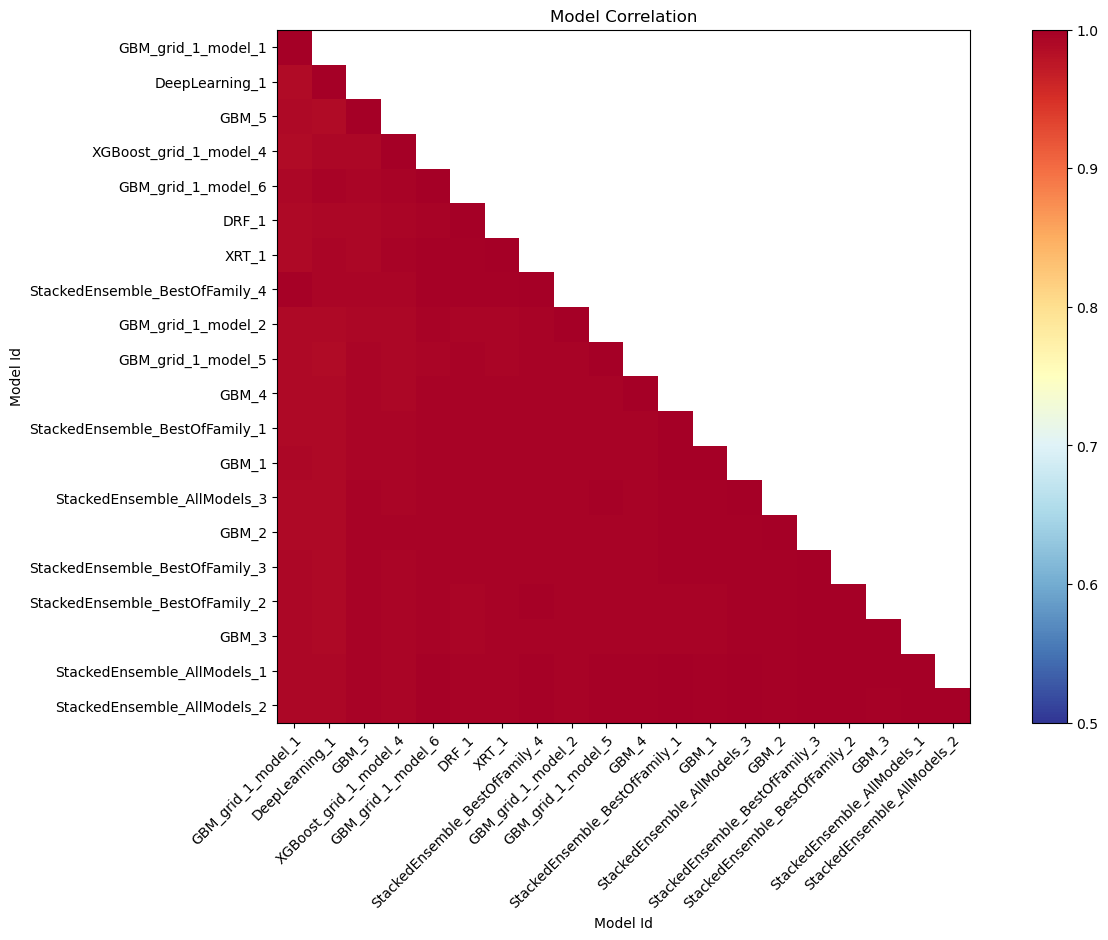

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

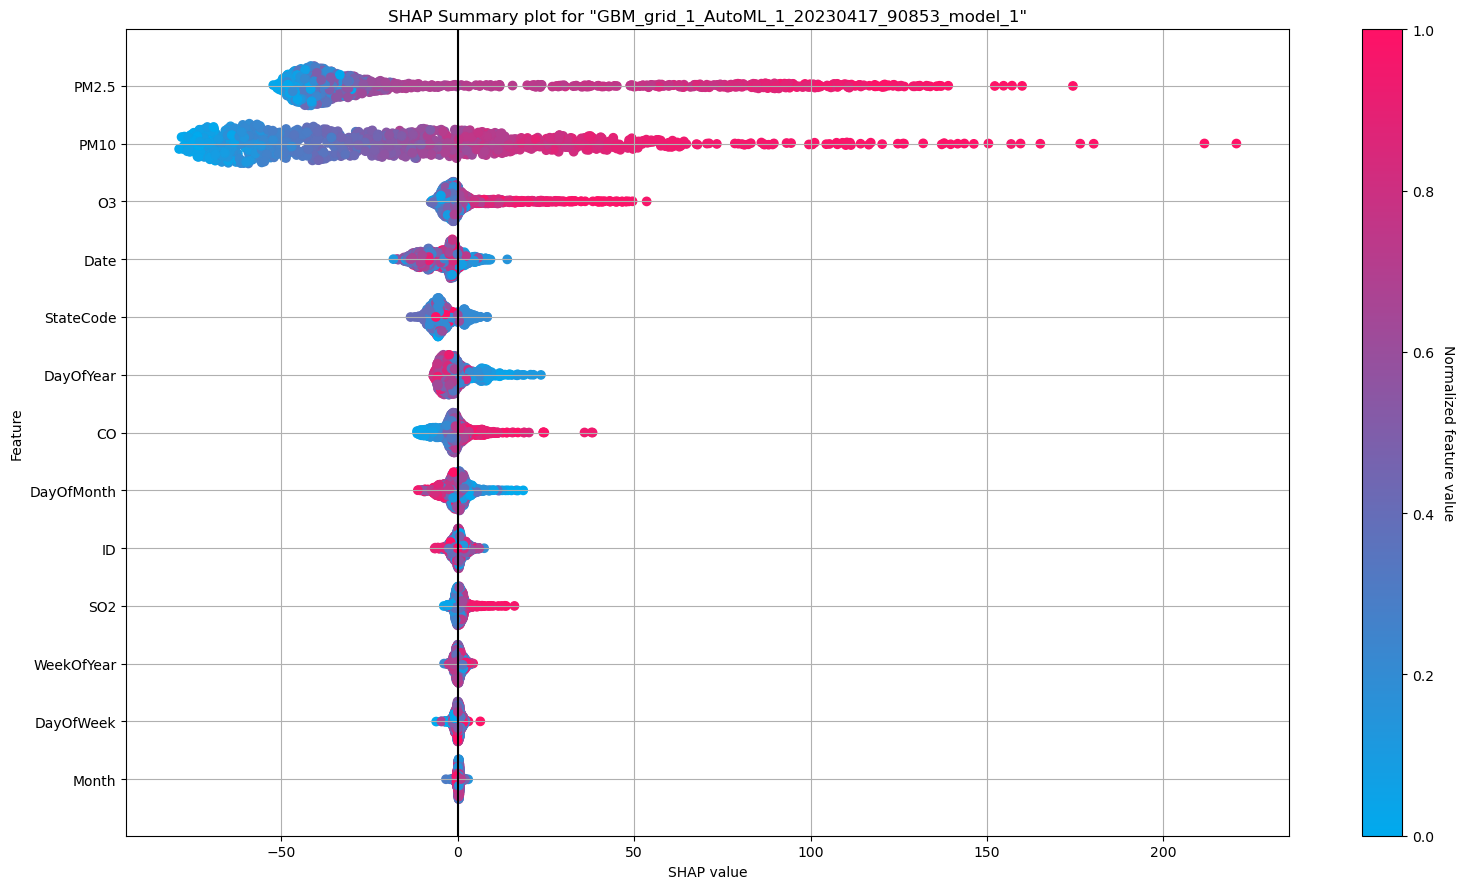

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

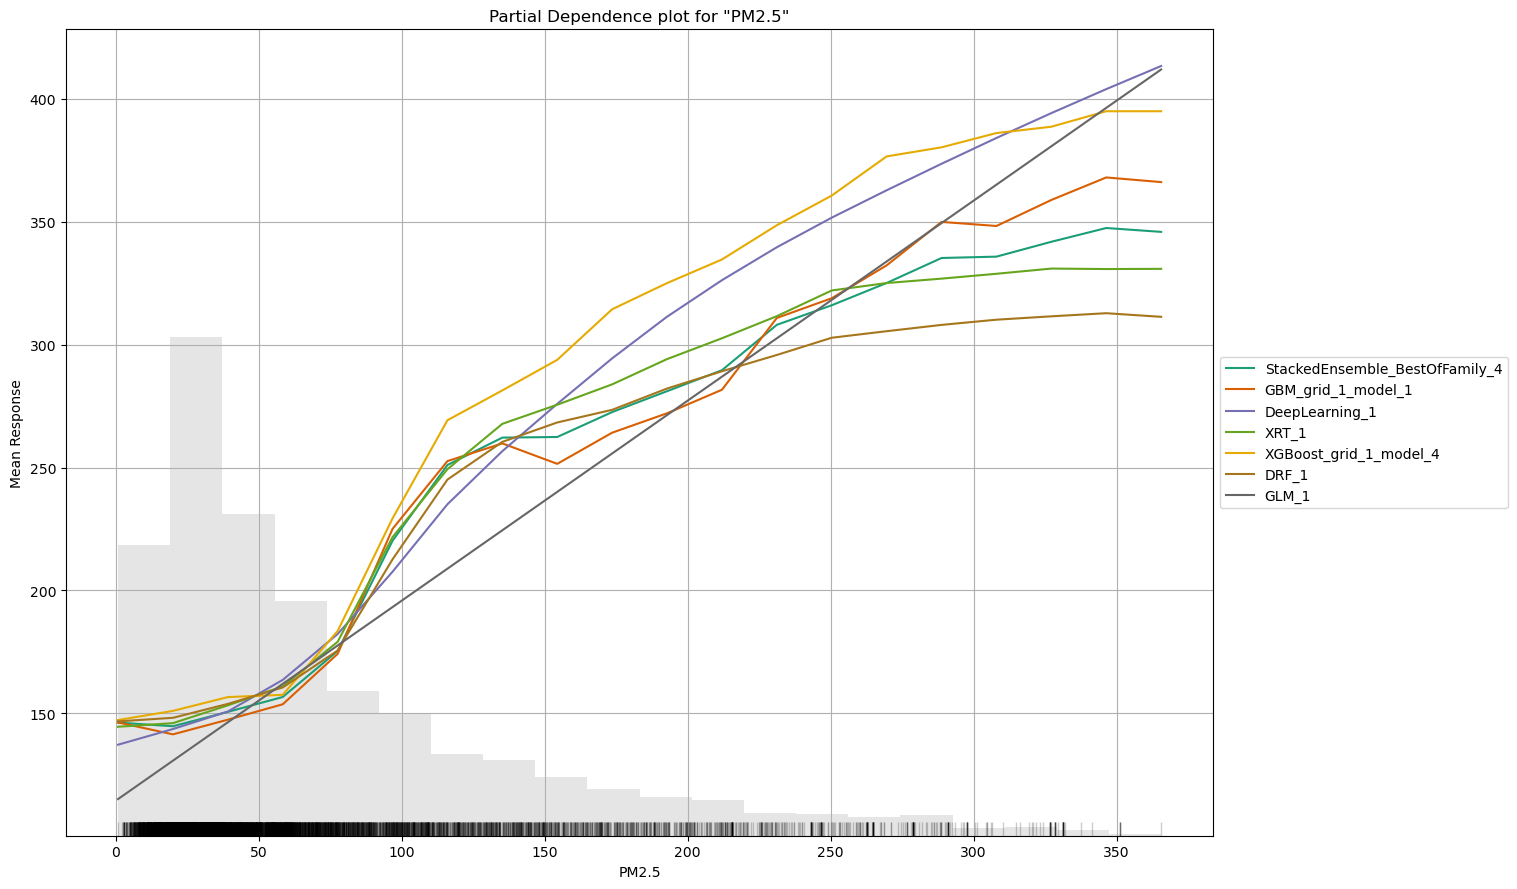

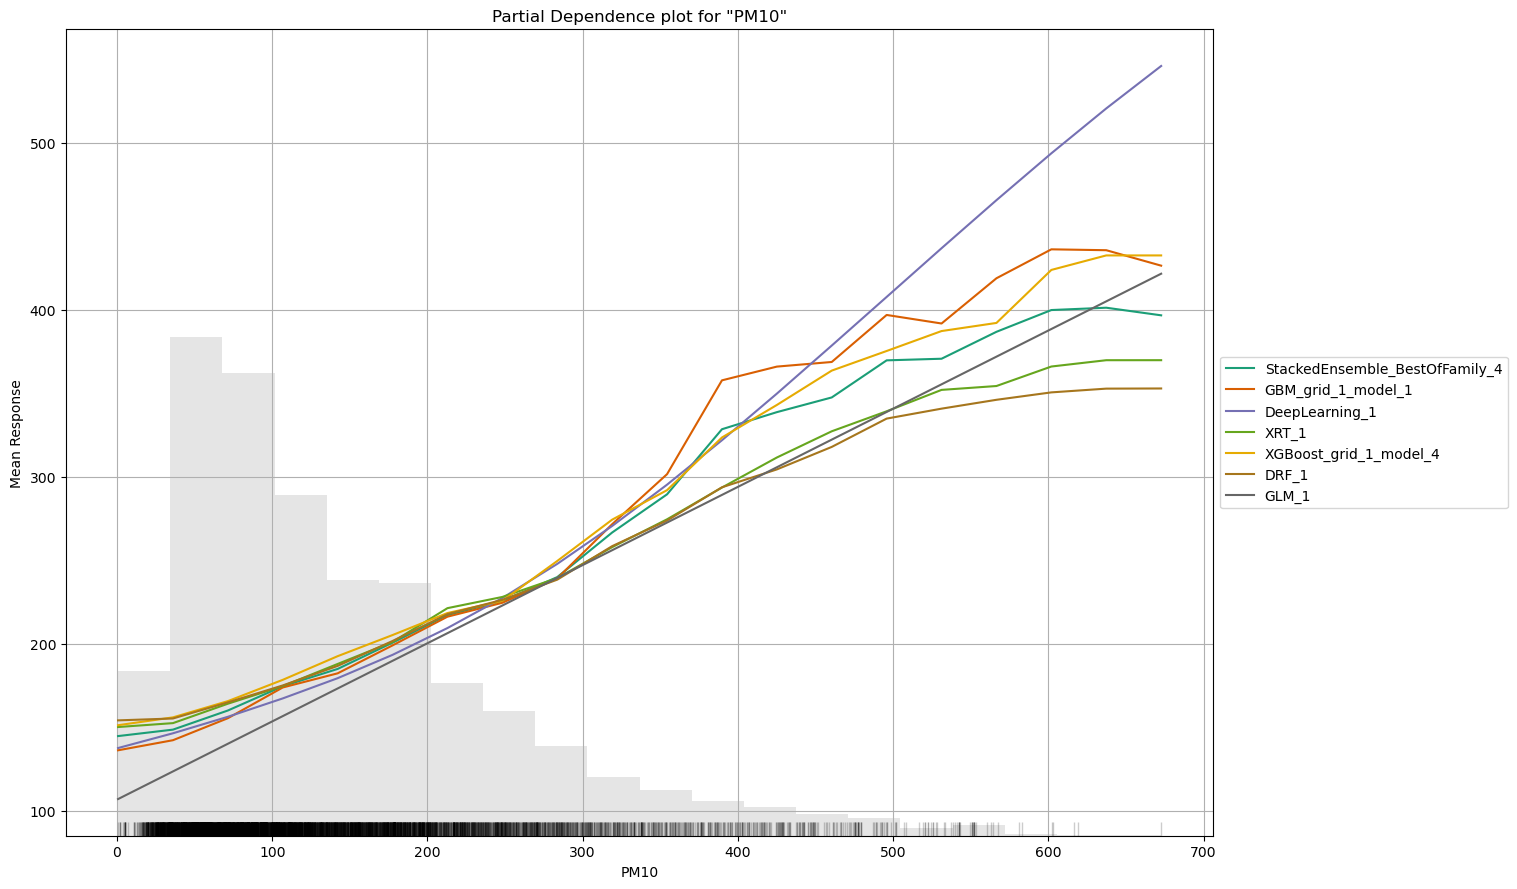

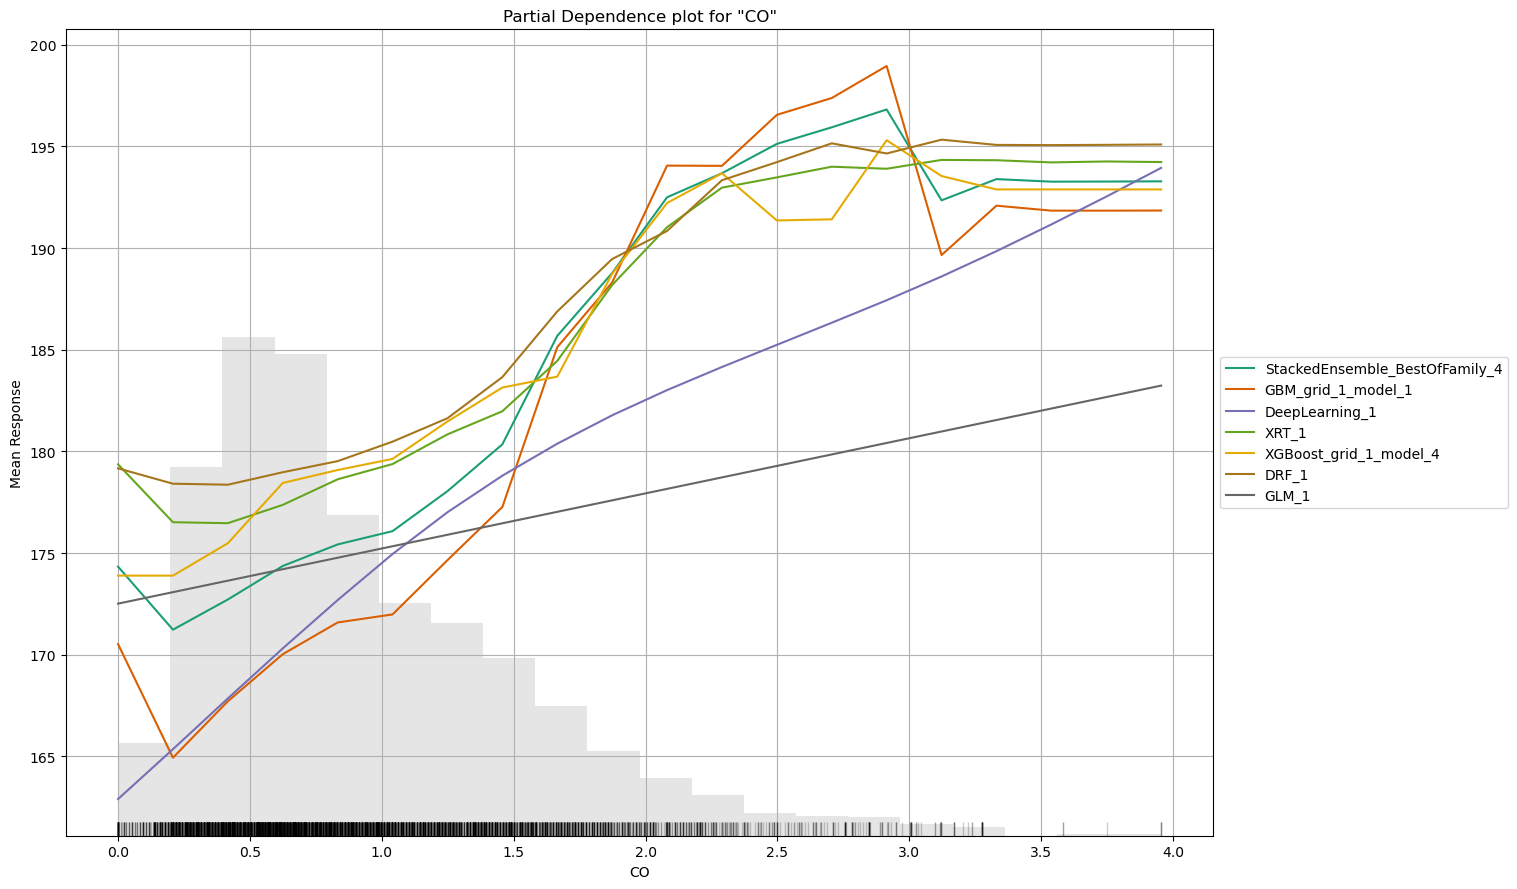

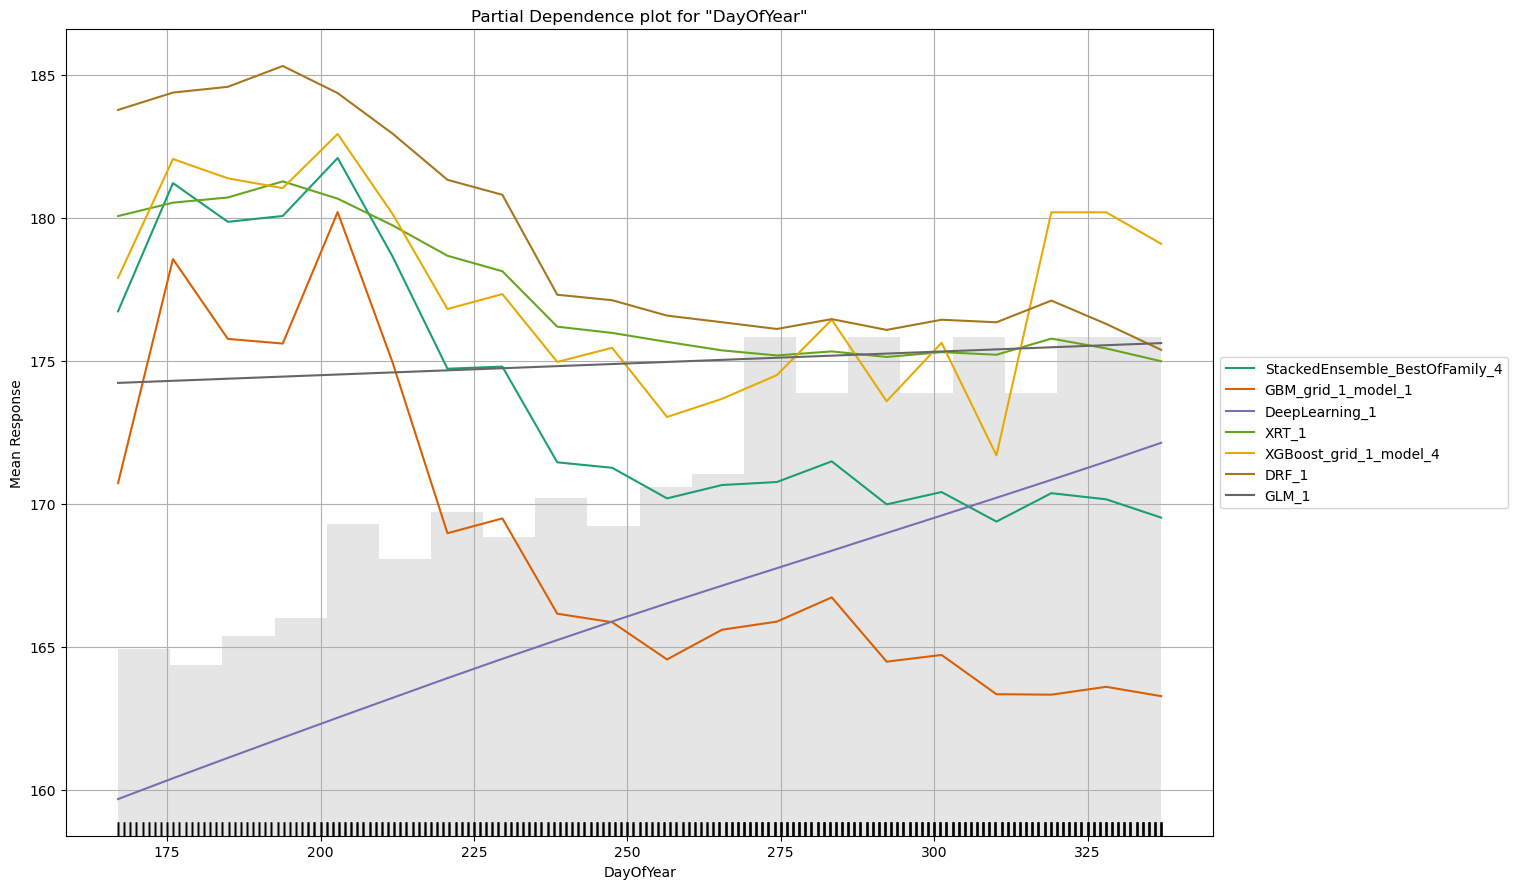

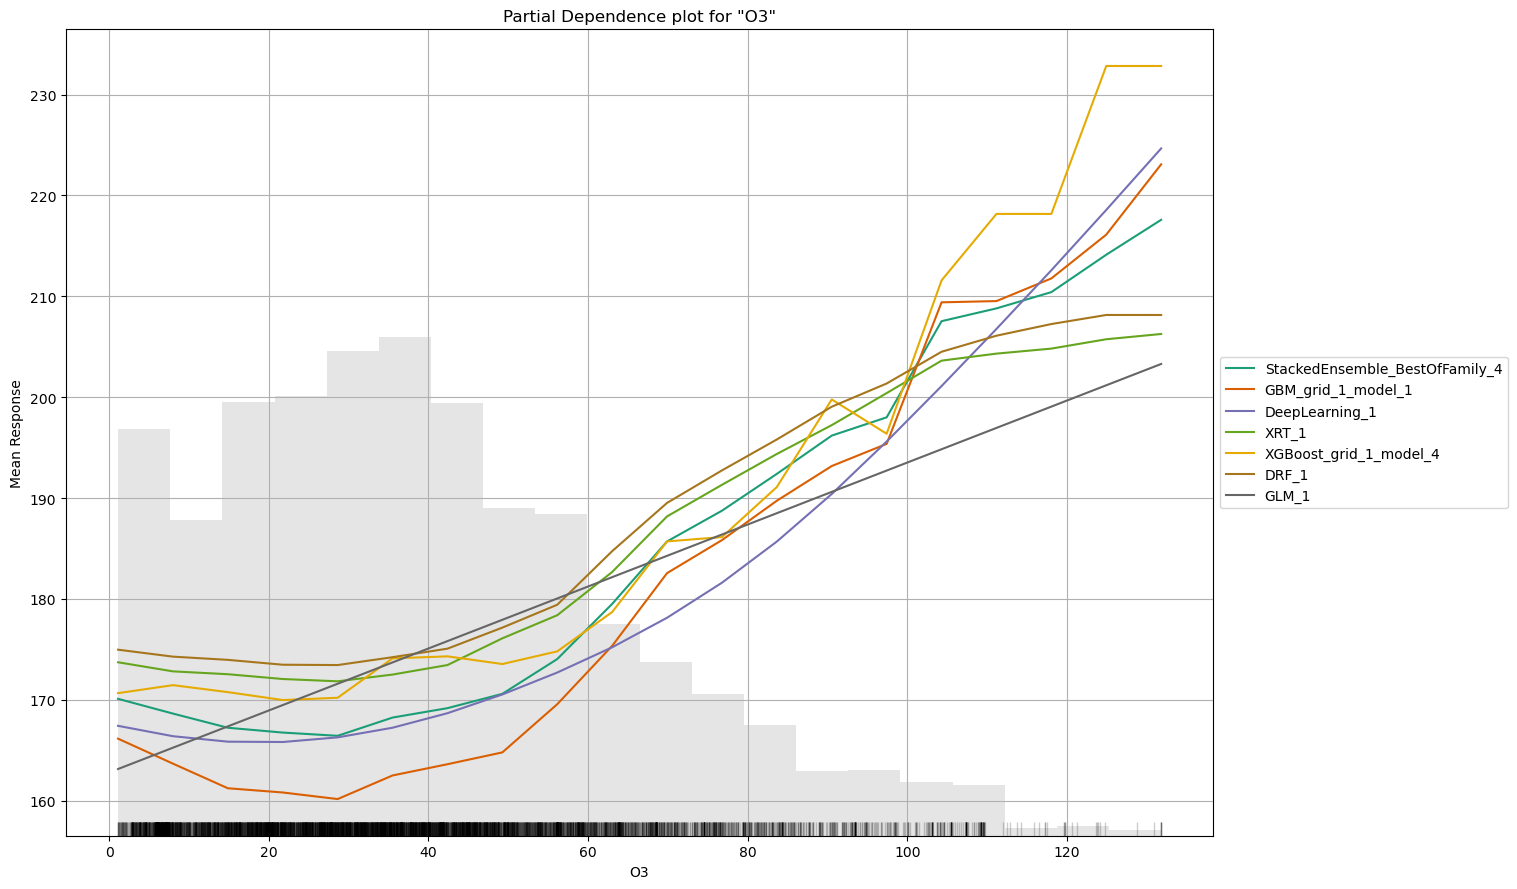

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

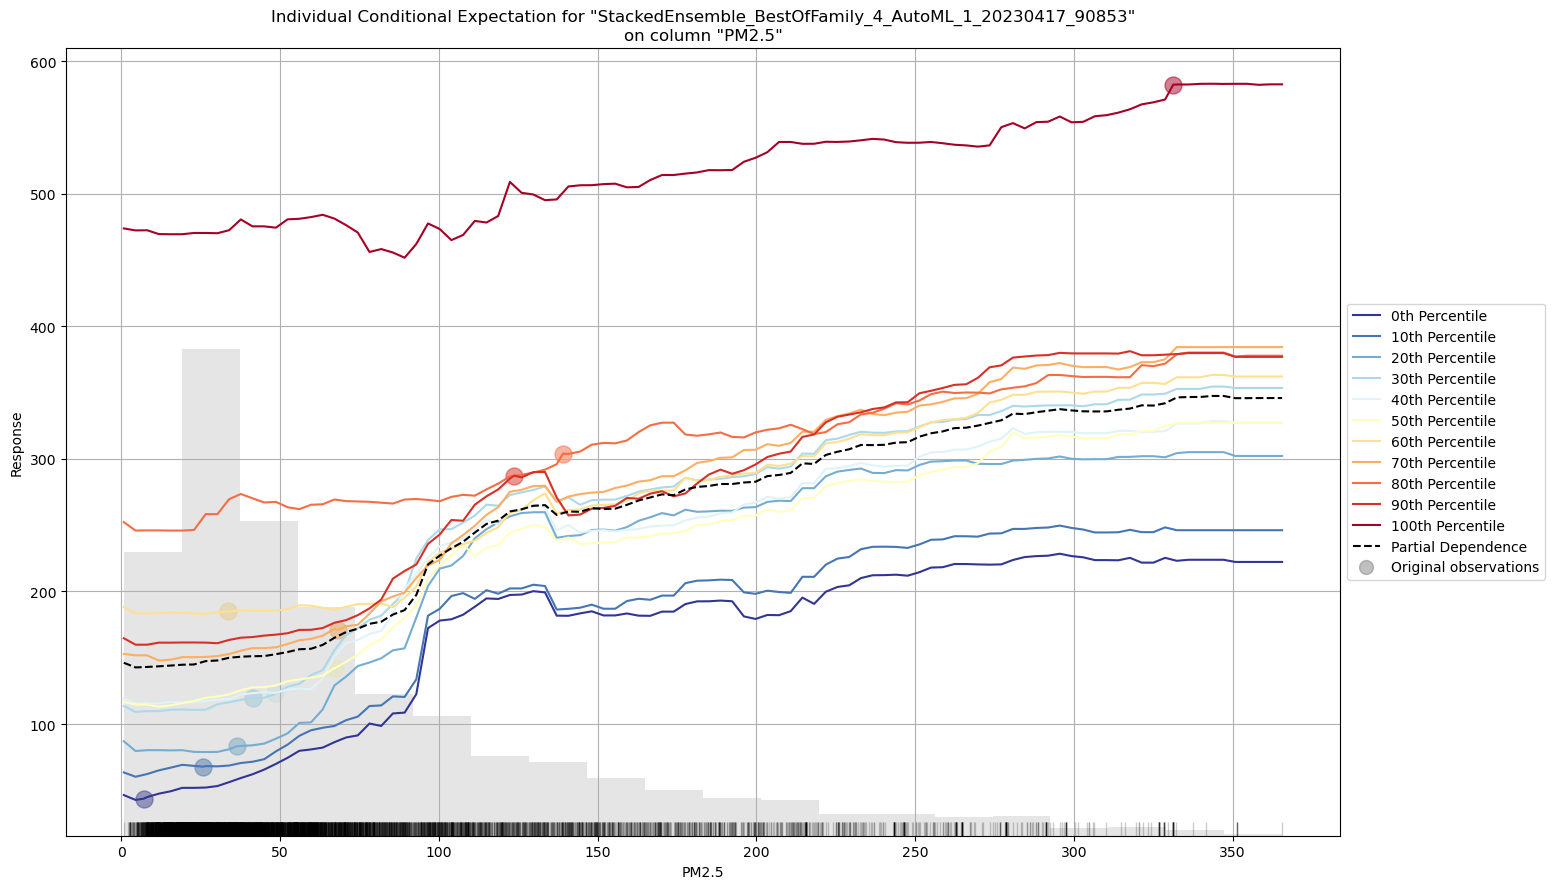

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_ad356601b5112e8ffeb72751f5354581> was cancelled by the user.

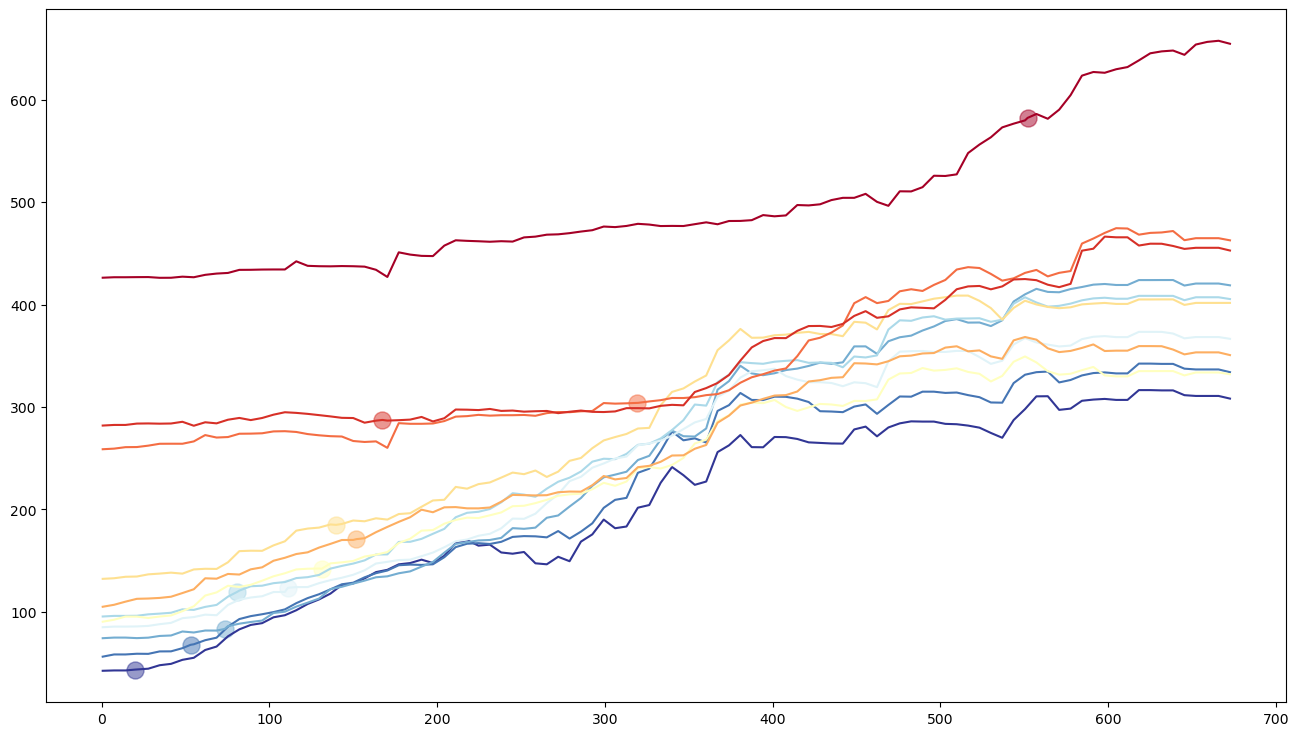

In [18]:
# Explain leader model & compare with all AutoML models
exa = aml.explain(hf_valid)
exa

In [36]:
leader_model = aml.leader

In [37]:
val_preds = leader_model.predict(hf_valid)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [38]:
val_preds.cbind(hf_valid['AQI'])

predict      AQI
---------  -------
 249.157   212.751
 264.663   235
 216.645   315
 139.255   172
  68.4216   75
 114.496    88
 114.223   116
 150.546   134
 147.292   145
 157.502   160
[5175 rows x 2 columns]

In [39]:
val_preds = val_preds.as_data_frame()

In [40]:
val_preds['predict']

0       249.156815
1       264.663086
2       216.645264
3       139.254608
4        68.421555
           ...    
5170     62.864826
5171     60.055710
5172     57.995464
5173     53.244267
5174     63.043964
Name: predict, Length: 5175, dtype: float64

In [41]:
hf_test.drop(['ID_Date'],axis =1)

StateCode    Date                   PM2.5     PM10       O3        CO      SO2    DayOfWeek    DayOfMonth    WeekOfYear    Month    DayOfYear    ID
-----------  -------------------  -------  -------  -------  --------  -------  -----------  ------------  ------------  -------  -----------  ----
AS           2022-12-04 00:00:00  18.8743  32.2575  42.9906  0.439418  16.214             6             4            48       12          338     0
AS           2022-12-05 00:00:00  19.8476  35.1829  40.8458  0.457979  16.144             0             5            49       12          339     0
AS           2022-12-06 00:00:00  20.3556  35.1829  39.7213  0.465124  16.1008            1             6            49       12          340     0
AS           2022-12-07 00:00:00  20.3556  35.1829  39.1319  0.465124  16.0742            2             7            49       12          341     0
AS           2022-12-08 00:00:00  20.3556  35.1829  38.8229  0.465124  16.0578            3             8            49       12          342     0
AS           2022-12-09 00:00:00  20.3556  35.1829  38.6609  0.465124  16.0476            4             9            49       12          343     0
AS           2022-12-10 00:00:00  20.3556  35.1829  38.5759  0.465124  16.0414            5            10            49       12          344     0
AS           2022-12-11 00:00:00  20.3556  35.1829  38.5314  0.465124  16.0375            6            11            49       12          345     0
AS           2022-12-12 00:00:00  20.3556  35.1829  38.5081  0.465124  16.0352            0            12            50       12          346     0
AS           2022-12-13 00:00:00  20.3556  35.1829  38.4958  0.465124  16.0337            1            13            50       12          347     0
[1120 rows x 13 columns]

In [42]:
preds = leader_model.predict(hf_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [43]:
preds = preds.as_data_frame()

In [44]:
sample_df = pd.read_csv('/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/sample_submission.csv')
display(sample_df.head().style.set_caption('Submission data'))

In [45]:
sample_df['AQI'] = preds

In [46]:
sample_df.to_csv('submission-1.csv',index = False)

In [47]:
sample_df

ID_Date        AQI
0      AS_4_2022-12-04  50.375931
1      AS_4_2022-12-05  47.275368
2      AS_4_2022-12-06  47.202522
3      AS_4_2022-12-07  48.480331
4      AS_4_2022-12-08  47.135197
...                ...        ...
1115  WB_16_2022-12-27  57.657356
1116  WB_16_2022-12-28  56.971378
1117  WB_16_2022-12-29  57.725216
1118  WB_16_2022-12-30  55.781635
1119  WB_16_2022-12-31  53.903912

[1120 rows x 2 columns]

# H2O AutoML on Data with AQI subindex calculated 

In [21]:
aqi_train_df = pd.read_csv('/kaggle/input/h2o-aqi-calc-data/new_train_df_after_aqi_calc (1).csv', parse_dates=["Date"])
display(aqi_train_df.head().style.set_caption('Train data'))

aqi_test_df = pd.read_csv('/kaggle/input/h2o-aqi-calc-data/new_test_df_after_aqi_calc.csv', parse_dates=["Date"])
display(aqi_test_df.head().style.set_caption('Test data'))

In [22]:
aqi_train = pd.DataFrame(columns = aqi_train_df.columns)  
aqi_valid = pd.DataFrame(columns = aqi_train_df.columns)  


for station in aqi_train_df['ID'].unique():
    print('NEW LOCATION -',station)
    location_train_df = aqi_train_df[aqi_train_df["ID"] == station]
    
    index = (80 * len(location_train_df['AQI'].values))//100
    
    t =  location_train_df.iloc[:index]
    v = location_train_df.iloc[index:]
    
    aqi_train = aqi_train.append(t)
    aqi_valid = aqi_valid.append(v)  

NEW LOCATION - 0
NEW LOCATION - 1
NEW LOCATION - 2
NEW LOCATION - 3
NEW LOCATION - 4
NEW LOCATION - 5
NEW LOCATION - 6
NEW LOCATION - 7
NEW LOCATION - 8
NEW LOCATION - 9
NEW LOCATION - 10
NEW LOCATION - 11
NEW LOCATION - 12
NEW LOCATION - 13
NEW LOCATION - 14
NEW LOCATION - 15
NEW LOCATION - 16
NEW LOCATION - 17
NEW LOCATION - 18
NEW LOCATION - 19
NEW LOCATION - 20
NEW LOCATION - 21
NEW LOCATION - 22
NEW LOCATION - 23
NEW LOCATION - 24
NEW LOCATION - 25
NEW LOCATION - 26
NEW LOCATION - 27
NEW LOCATION - 28
NEW LOCATION - 29
NEW LOCATION - 30
NEW LOCATION - 31
NEW LOCATION - 32
NEW LOCATION - 33
NEW LOCATION - 34
NEW LOCATION - 35
NEW LOCATION - 36
NEW LOCATION - 37
NEW LOCATION - 38
NEW LOCATION - 39


In [23]:
aqi_train.shape,aqi_valid.shape,aqi_test_df.shape

((20648, 23), (5175, 23), (1120, 22))

In [24]:
from __future__ import print_function
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  ----------------------------------
H2O_cluster_uptime:         26 mins 03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.2
H2O_cluster_version_age:    1 month and 7 days
H2O_cluster_name:           H2O_from_python_unknownUser_jflayh
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.155 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.12 final
--------------------------  ----------------------------------

In [25]:
hf_train = h2o.H2OFrame(aqi_train)
hf_valid = h2o.H2OFrame(aqi_valid)
hf_test = h2o.H2OFrame(aqi_test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
# Identify predictors and response
X = hf_train.columns
y = "AQI"
X.remove(y)

In [41]:
hf = hf_train.rbind(hf_valid)

In [42]:
hf.shape

(25823, 23)

In [43]:
import h2o
from h2o.automl import H2OAutoML

aml = H2OAutoML(seed = 42,   nfolds = 0,
         sort_metric = 'MAE',verbosity = 'info',keep_cross_validation_predictions = True,
max_runtime_secs=1200)

aml.train(x = X, 
          y = y,
          training_frame = hf)

AutoML progress: |
12:54:38.161: Project: AutoML_4_20230417_125438
12:54:38.162: Cross-validation disabled by user: no fold column nor nfolds > 1.
12:54:38.173: Setting stopping tolerance adaptively based on the training frame: 0.006222954883843316
12:54:38.173: Build control seed: 42
12:54:38.178: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
12:54:38.293: training frame: Frame key: AutoML_4_20230417_125438_training_py_243_sid_85bd    cols: 23    rows: 23224  chunks: 2    size: 2555618  checksum: -2783237252952355943
12:54:38.294: validation frame: Frame key: AutoML_4_20230417_125438_validation_py_243_sid_85bd    cols: 23    rows: 2599  chunks: 2    size: 288241  checksum: 2718204096869568550
12:54:38.295: leaderboard frame: Frame key: AutoML_4_20230417_125438_validation_py_243_sid_85bd    cols: 23    rows: 2599  chunks: 2    size: 288241  checksum: 271820409

Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_grid_1_AutoML_4_20230417_125438_model_14


Model Summary: 
    number_of_trees
--  -----------------
    125

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 75.37551446300978
RMSE: 8.681907305598799
MAE: 5.565740565903796
RMSLE: 0.06384854918811382
Mean Residual Deviance: 75.37551446300978

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 549.2882129546094
RMSE: 23.436898535314125
MAE: 15.176763781862746
RMSLE: 0.13849372132413684
Mean Residual Deviance: 549.2882129546094

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2023-04-17 12:57:38  1 min 39.975 sec  0.0                227.37889857633203  189.52075851238723  51701.163517785884   230.15317259165244  191.39086909512457  52970.482854002956
     2023-04-17 12:57:39  1 min 40.212 sec  5.0                53.34823369583648   37.38879737183015   2846.0340384655824   55.479482787344516  38.249499168704226  3077.973010351256
     2023-04-17 12:57:39  1 min 40.624 sec  10.0               29.936132625172487  19.432511121784042  896.1720365519166    32.48282715364591   20.80103298479339   1055.1340598936358
     2023-04-17 12:57:40  1 min 41.102 sec  15.0               24.456953685382476  15.964923664983946  598.1425835689435    28.203277969277792  18.217106418088566  795.42488821235
     2023-04-17 12:57:40  1 min 41.609 sec  20.0               21.695325928523488  14.202556761141444  470.6871671448635    26.74756933179737   17.35538545485963   715.4324651593071
     2023-04-17 12:57:41  1 min 42.184 sec  25.0               19.84278508162431   13.03061832336159   393.7361197955323    25.75176775463991   16.77800188948898   663.1535424889119
     2023-04-17 12:57:41  1 min 42.704 sec  30.0               18.980168019100475  12.51172885659067   360.24677803328444   25.424164700165957  16.596706347815942  646.3881507011647
     2023-04-17 12:57:42  1 min 43.253 sec  35.0               17.94866887221474   11.815586570415503  322.15471428441026   25.181468154743616  16.39938809716642   634.1063384283668
     2023-04-17 12:57:42  1 min 43.764 sec  40.0               16.976664733426784  11.21082245285167   288.2071454711767    24.754295933179332  16.152625651577885  612.7751671474188
     2023-04-17 12:57:43  1 min 44.281 sec  45.0               16.252186880578694  10.737372096513742  264.1335784012542    24.582854397610408  16.02757352863472   604.3167303341135
---  ---                  ---               ---                ---                 ---                 ---                  ---                 ---                 ---
     2023-04-17 12:57:47  1 min 48.332 sec  80.0               12.011084971541184  7.858269278443849   144.26616219358246   23.735786859720356  15.437858754004273  563.3875778500735
     2023-04-17 12:57:47  1 min 48.987 sec  85.0               11.494520339840038  7.501590481348133   132.12399784299635   23.67774054039637   15.37780924713029   560.6353970983299
     2023-04-17 12:57:48  1 min 49.647 sec  90.0               10.978086384456526  7.169892646631536   120.51838066458978   23.61557710870801   15.31865230162541   557.6954821773338
     2023-04-17 12:57:49  1 min 50.340 sec  95.0               10.60923328697215   6.9353418263574325  112.55583093739791   23.618658629696576  15.310117944656495  557.8410354661405
     2023-04-17 12:57:50  1 min 51.069 sec  100.0              10.184403381751629  6.6315951397860005  103.72207224223403   23.536614773341046  15.235107555440775  553.972234988656
     2023-04-17 12:57:50  1 min 51.805 sec  105.0              9.783117881290025   6.351321924812745   95.709395479

In [44]:
lb = aml.leaderboard
lb

model_id                                              mae     rmse      mse     rmsle    mean_residual_deviance
------------------------------------------------  -------  -------  -------  --------  ------------------------
XGBoost_grid_1_AutoML_4_20230417_125438_model_14  15.1768  23.4369  549.288  0.138494                   549.288
XGBoost_grid_1_AutoML_4_20230417_125438_model_28  15.4077  23.5444  554.339  0.138333                   554.339
GBM_grid_1_AutoML_4_20230417_125438_model_45      15.4879  23.8523  568.934  0.136925                   568.934
GBM_grid_1_AutoML_4_20230417_125438_model_5       15.634   23.9228  572.303  0.138241                   572.303
XGBoost_grid_1_AutoML_4_20230417_125438_model_22  15.6366  24.0139  576.667  0.140678                   576.667
GBM_grid_1_AutoML_4_20230417_125438_model_63      15.676   23.8734  569.94   0.139682                   569.94
GBM_3_AutoML_4_20230417_125438                    15.7045  23.7991  566.398  0.140735                   566.398
XGBoost_grid_1_AutoML_4_20230417_125438_model_40  15.7715  24.1437  582.918  0.141095                   582.918
GBM_grid_1_AutoML_4_20230417_125438_model_68      15.7719  23.9847  575.266  0.14013                    575.266
XGBoost_grid_1_AutoML_4_20230417_125438_model_65  15.8179  23.8326  567.992  0.142129                   567.992
[158 rows x 6 columns]

In [45]:
leader_model = aml.leader

In [53]:
val_preds = leader_model.predict(hf_valid)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [54]:
val_preds.cbind(hf_valid['AQI'])

predict      AQI
---------  -------
 232.869   212.751
 255.21    235
 266.331   315
 166.43    172
  76.0115   75
 129.617    88
 115.652   116
 137.468   134
 142.811   145
 160.837   160
[5175 rows x 2 columns]

In [47]:
preds = leader_model.predict(hf_test)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [48]:
preds = preds.as_data_frame()

In [49]:
sample_df = pd.read_csv('/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/sample_submission.csv')
display(sample_df.head().style.set_caption('Submission data'))

In [50]:
sample_df['AQI'] = preds

In [51]:
sample_df.to_csv('submission.csv',index=False)

In [52]:
sample_df

ID_Date        AQI
0      AS_4_2022-12-04  57.404606
1      AS_4_2022-12-05  51.790138
2      AS_4_2022-12-06  47.533073
3      AS_4_2022-12-07  47.000015
4      AS_4_2022-12-08  47.462433
...                ...        ...
1115  WB_16_2022-12-27  52.815525
1116  WB_16_2022-12-28  51.109470
1117  WB_16_2022-12-29  50.519711
1118  WB_16_2022-12-30  49.666908
1119  WB_16_2022-12-31  46.678448

[1120 rows x 2 columns]

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                 rmse      mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
----------------------------------------------------  -------  -------  -------  --------  ------------------------  ------------------  -------------------------  ------------
XGBoost_grid_1_AutoML_3_20230417_122604_model_140     27.2191  740.881  19.6858  0.192619                   740.881                6998                   0.013708  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_226     27.4747  754.861  19.6897  0.193777                   754.861                5694                   0.012446  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_14      27.7073  767.694  19.9093  0.195468                   767.694                4804                   0.011868  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_6       27.7626  770.761  19.9805  0.196022                   770.761                3469                   0.009657  XGBoost
DeepLearning_grid_2_AutoML_3_20230417_122604_model_1  27.7851  772.012  20.1488  0.203499                   772.012               33760                   0.00628   DeepLearning
XGBoost_grid_1_AutoML_3_20230417_122604_model_176     27.8663  776.531  20.0423  0.197781                   776.531                4162                   0.011748  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_22      27.9109  779.02   20.0347  0.196739                   779.02                 2501                   0.010012  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_126     27.915   779.249  19.8826  0.196288                   779.249                4307                   0.008788  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_213     27.9403  780.66   20.1135  0.195082                   780.66                 4048                   0.009852  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_90      27.9574  781.617  20.0792  0.196623                   781.617                4040                   0.010246  XGBoost
GBM_grid_1_AutoML_3_20230417_122604_model_44          28.1984  795.15   20.1808  0.196926                   795.15                 1188                   0.028651  GBM
DeepLearning_grid_1_AutoML_3_20230417_122604_model_3  28.2166  796.178  20.4463  0.2072                     796.178               63127                   0.012108  DeepLearning
DeepLearning_grid_1_AutoML_3_20230417_122604_model_2  28.2299  796.929  20.4285  0.210512                   796.929               47953                   0.012039  DeepLearning
XGBoost_grid_1_AutoML_3_20230417_122604_model_89      28.2312  797      20.552   0.202037                   797                    5614                   0.009658  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_120     28.2473  797.909  20.5013  0.200799                   797.909                4075                   0.00852   XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_152     28.294   800.552  20.8543  0.200495                   800.552                5484                   0.015343  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_118     28.2977  800.76   20.342   0.200566                   800.76                 2556                   0.002537  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_172     28.3035  801.086  20.3646  0.198289                   801.086                1782                   0.004344  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_156     28.3046  801.149  20.2199  0.198083                   801.149                8095                   0.014868  XGBoost
GBM_grid_1_AutoML_3_20230417_122604_model_43          28.3313  802.662  20.4023  0.200661                   802.662                1228                   0.018354  GBM
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

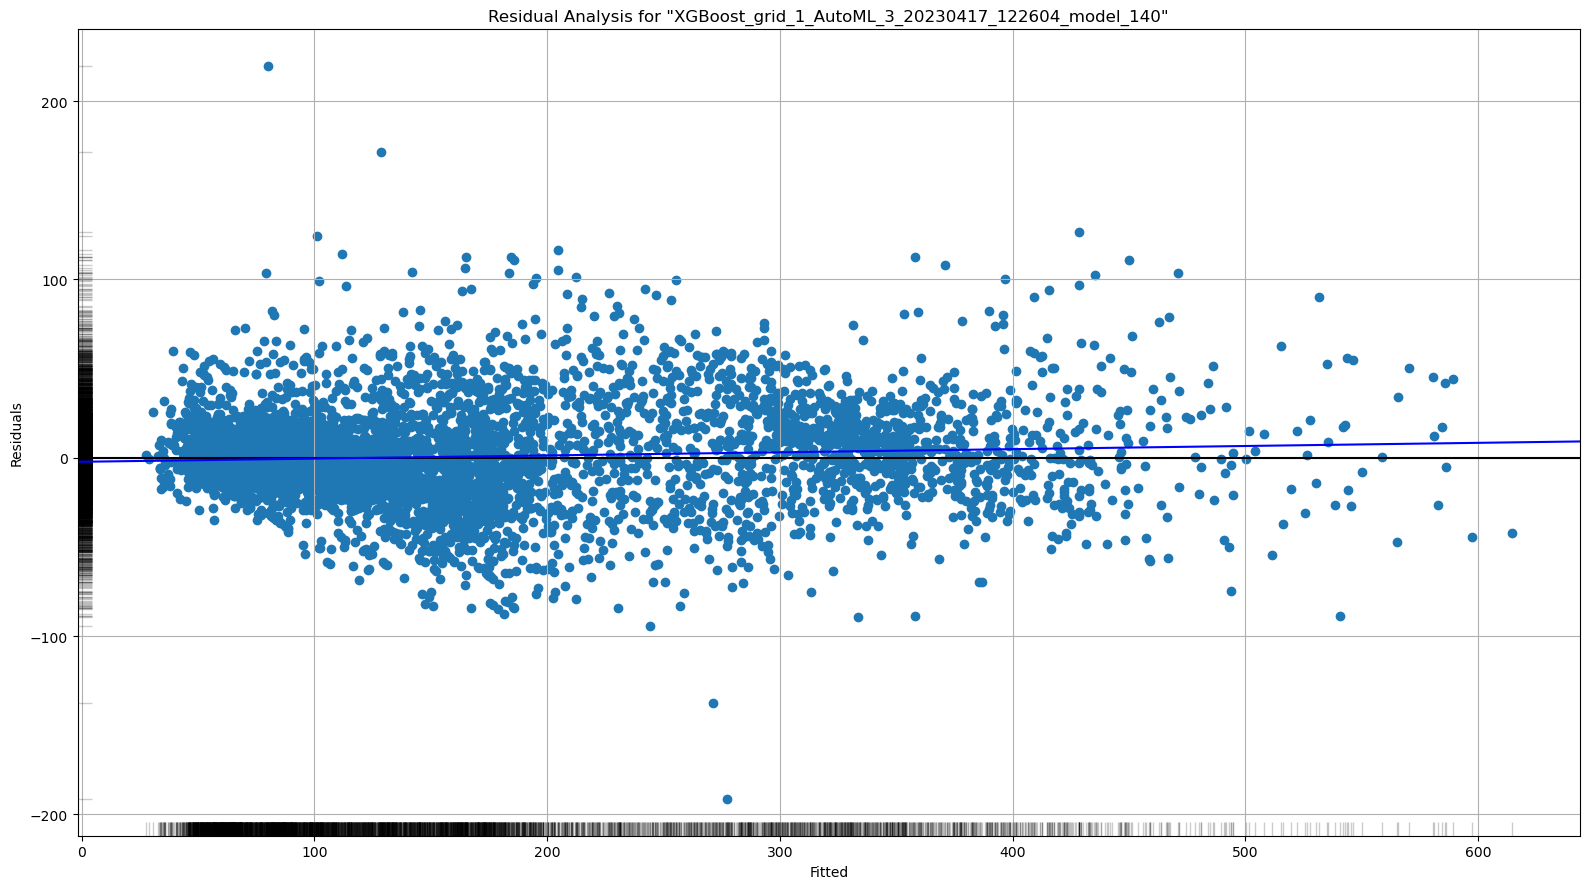

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

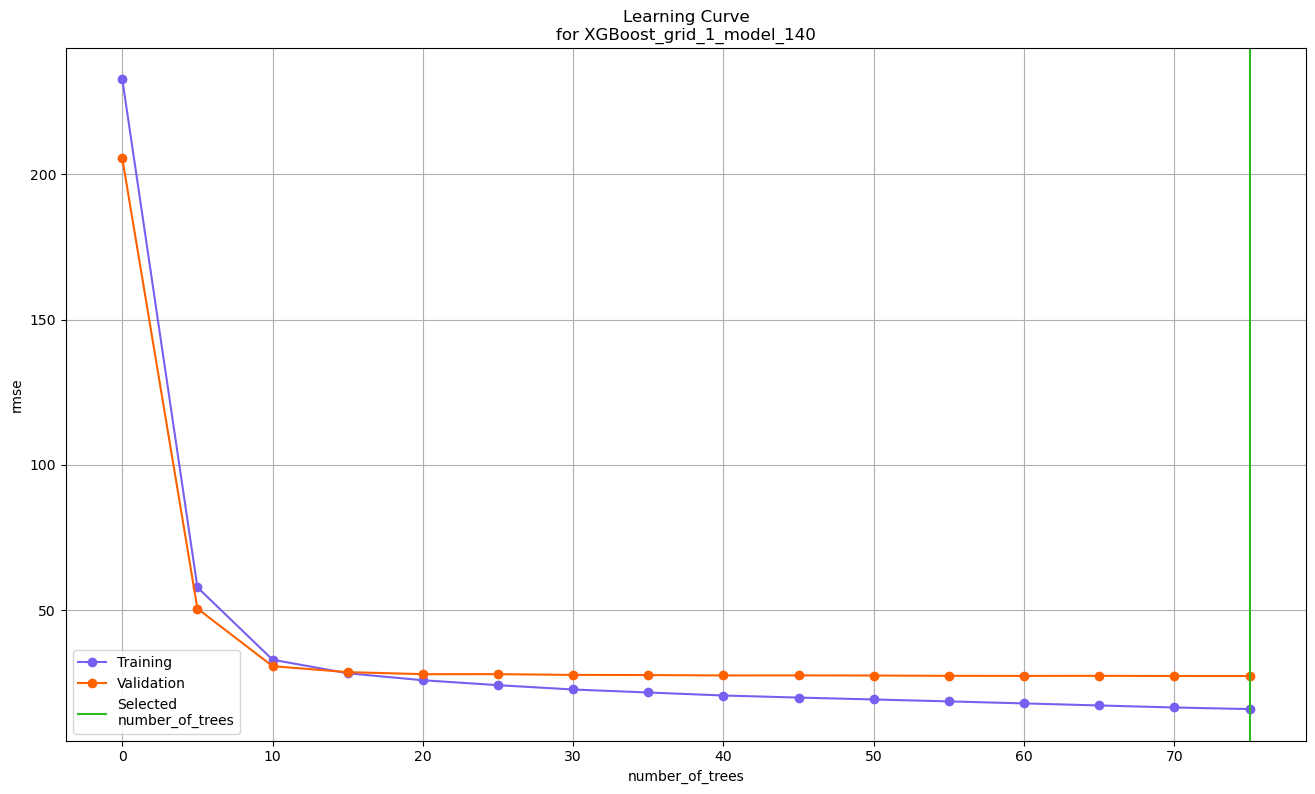

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

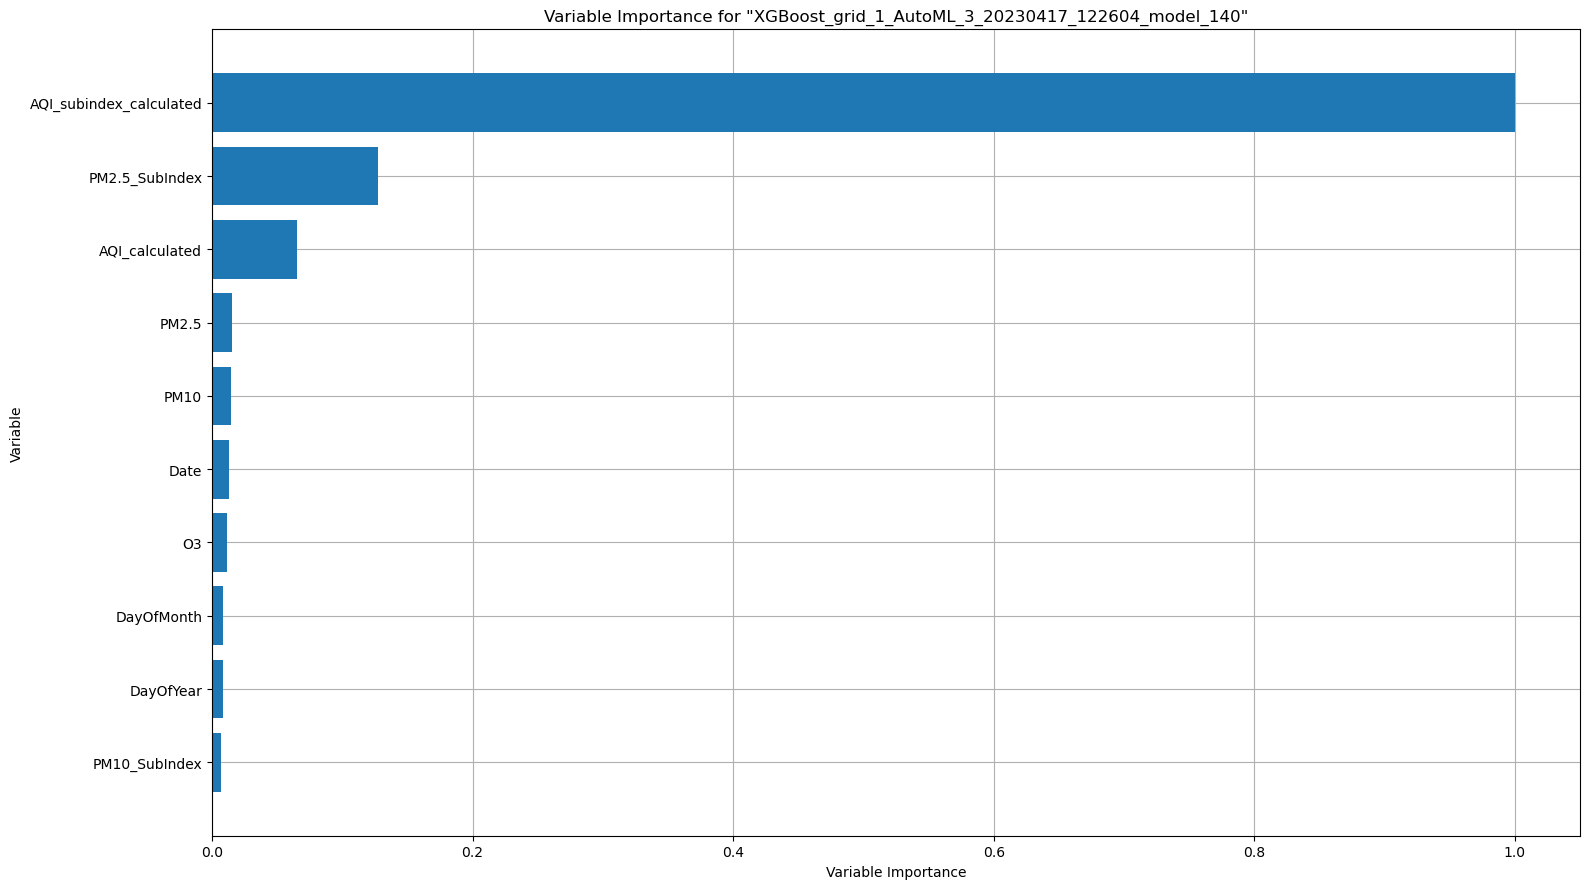

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

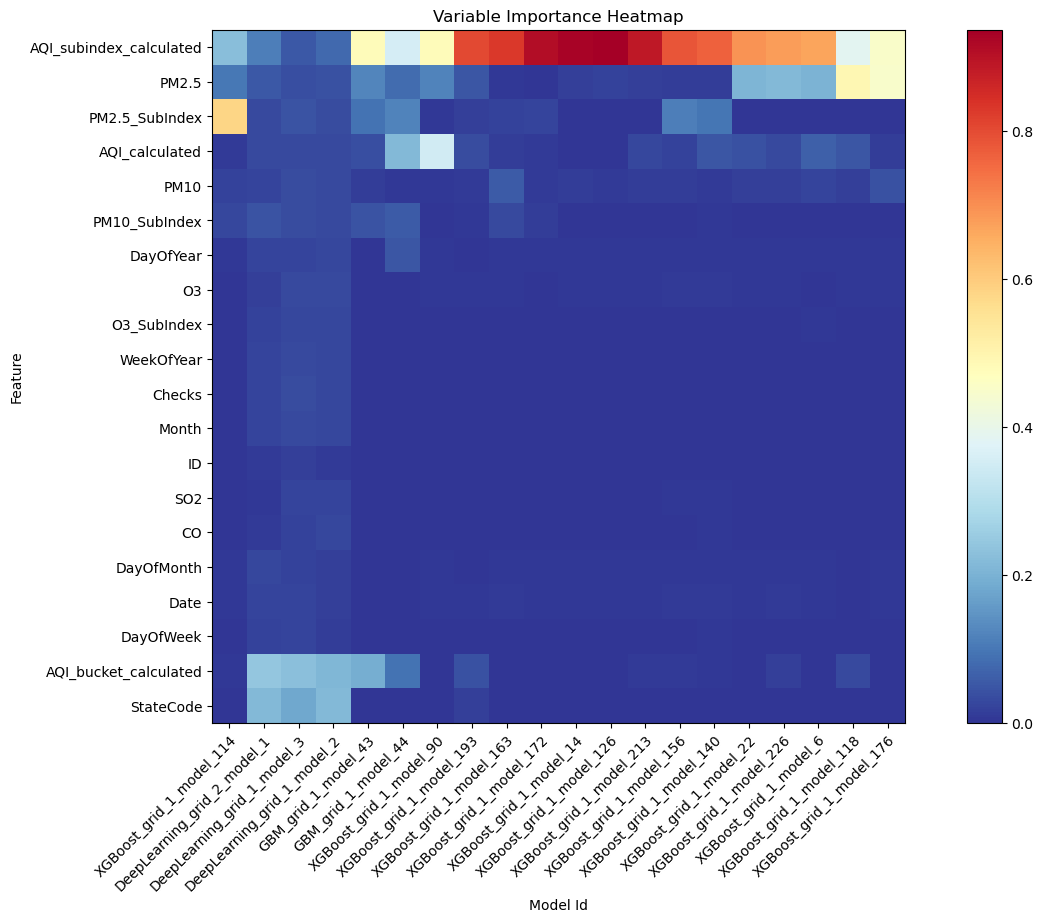

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

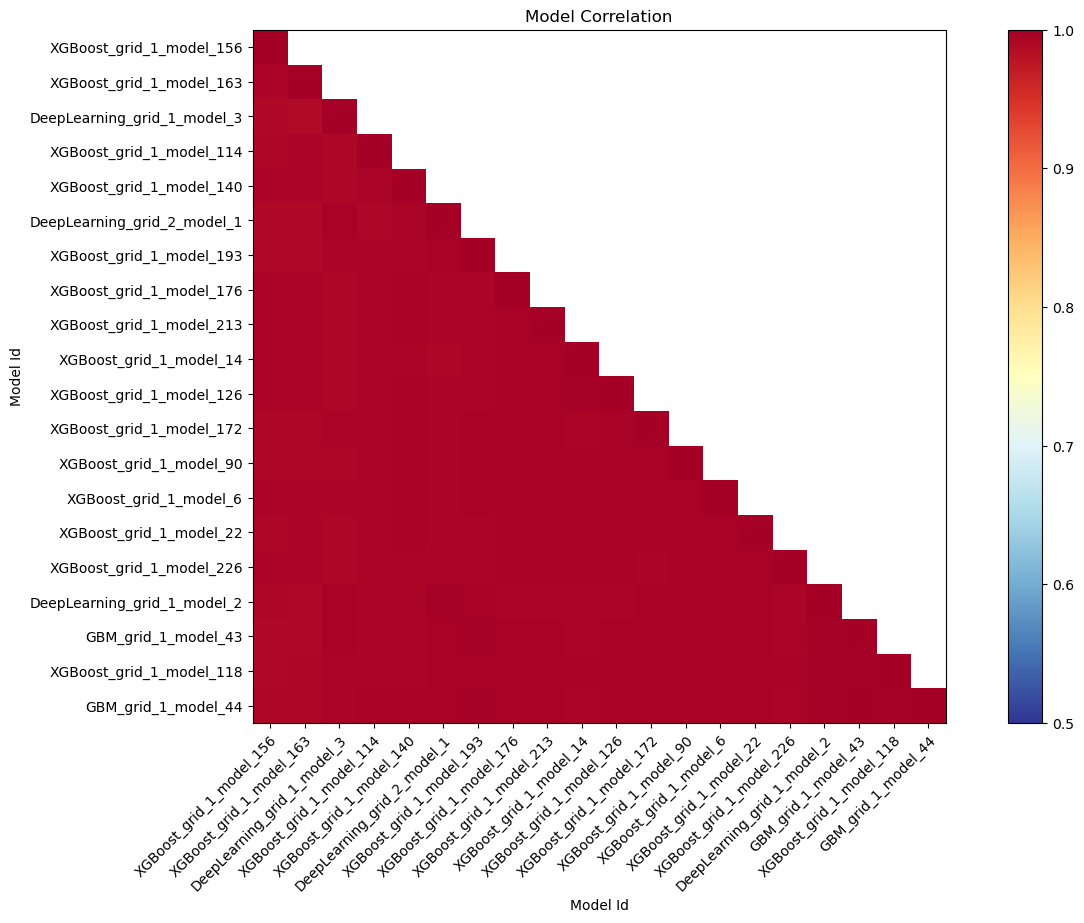

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

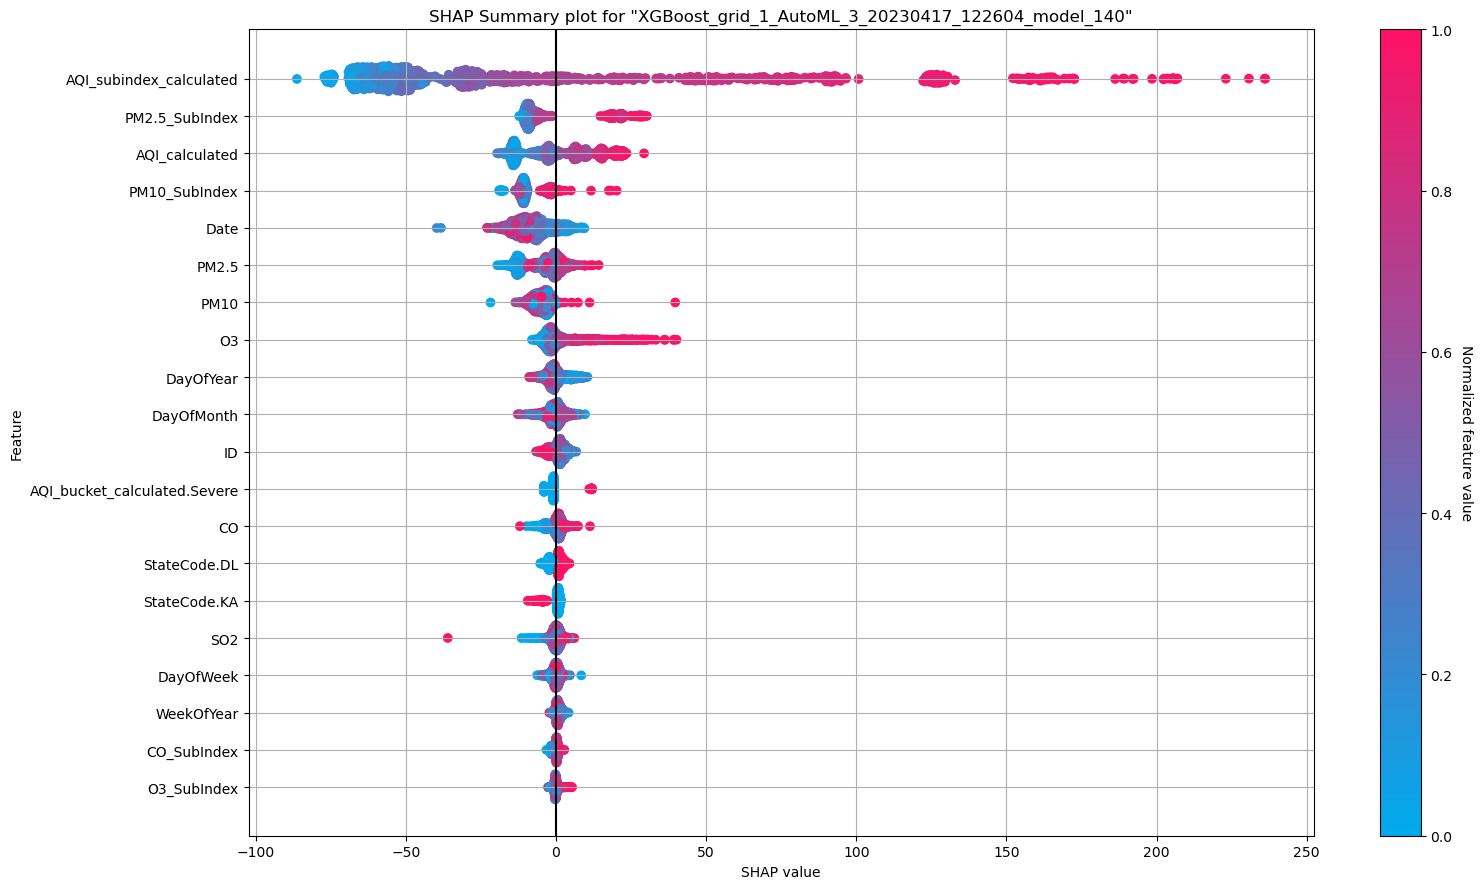

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

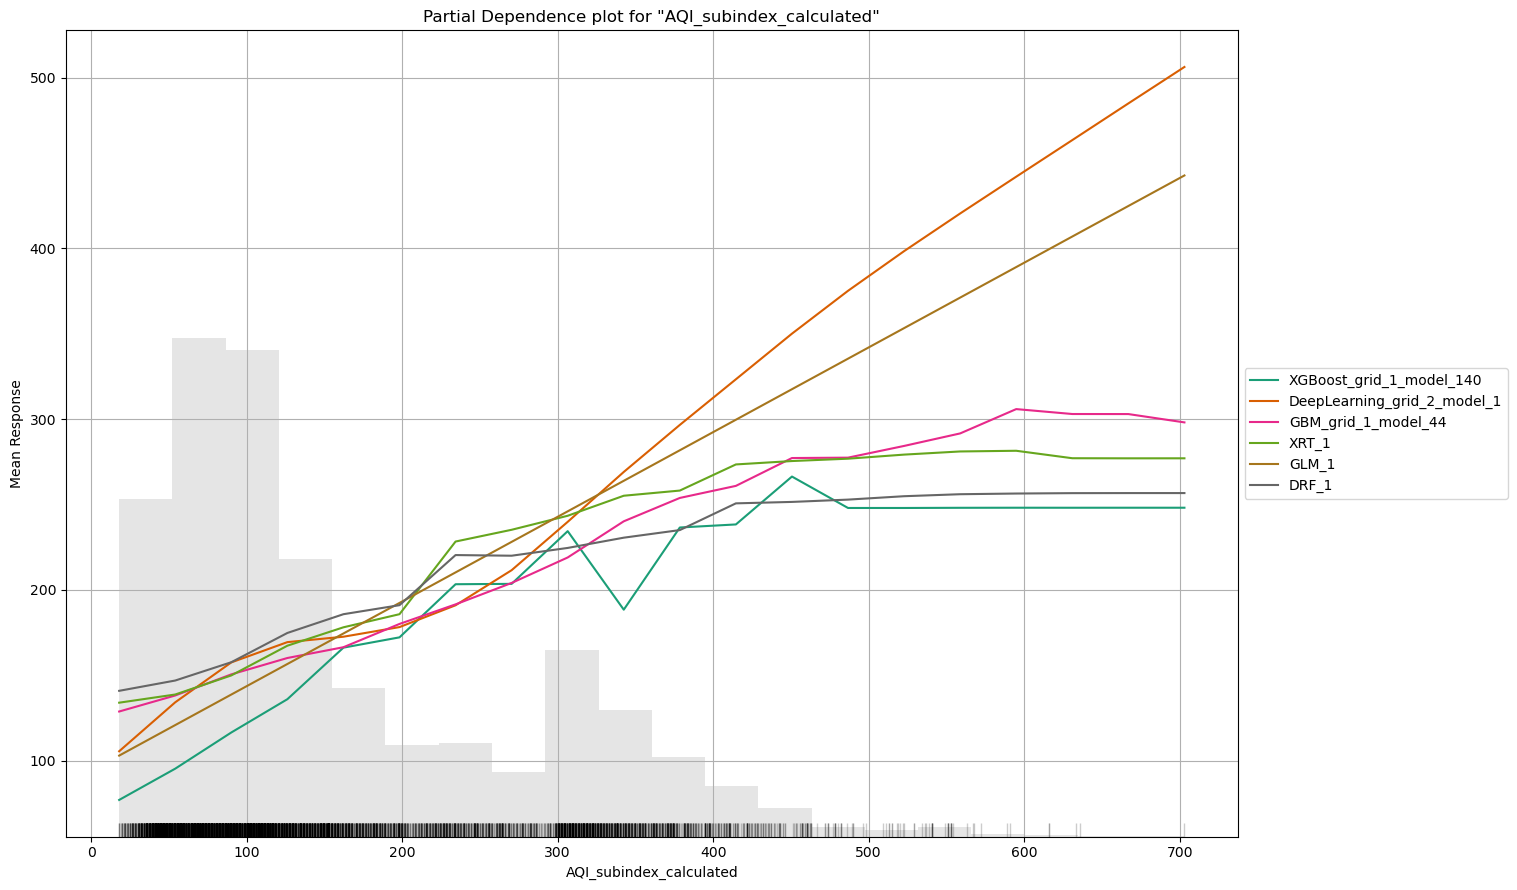

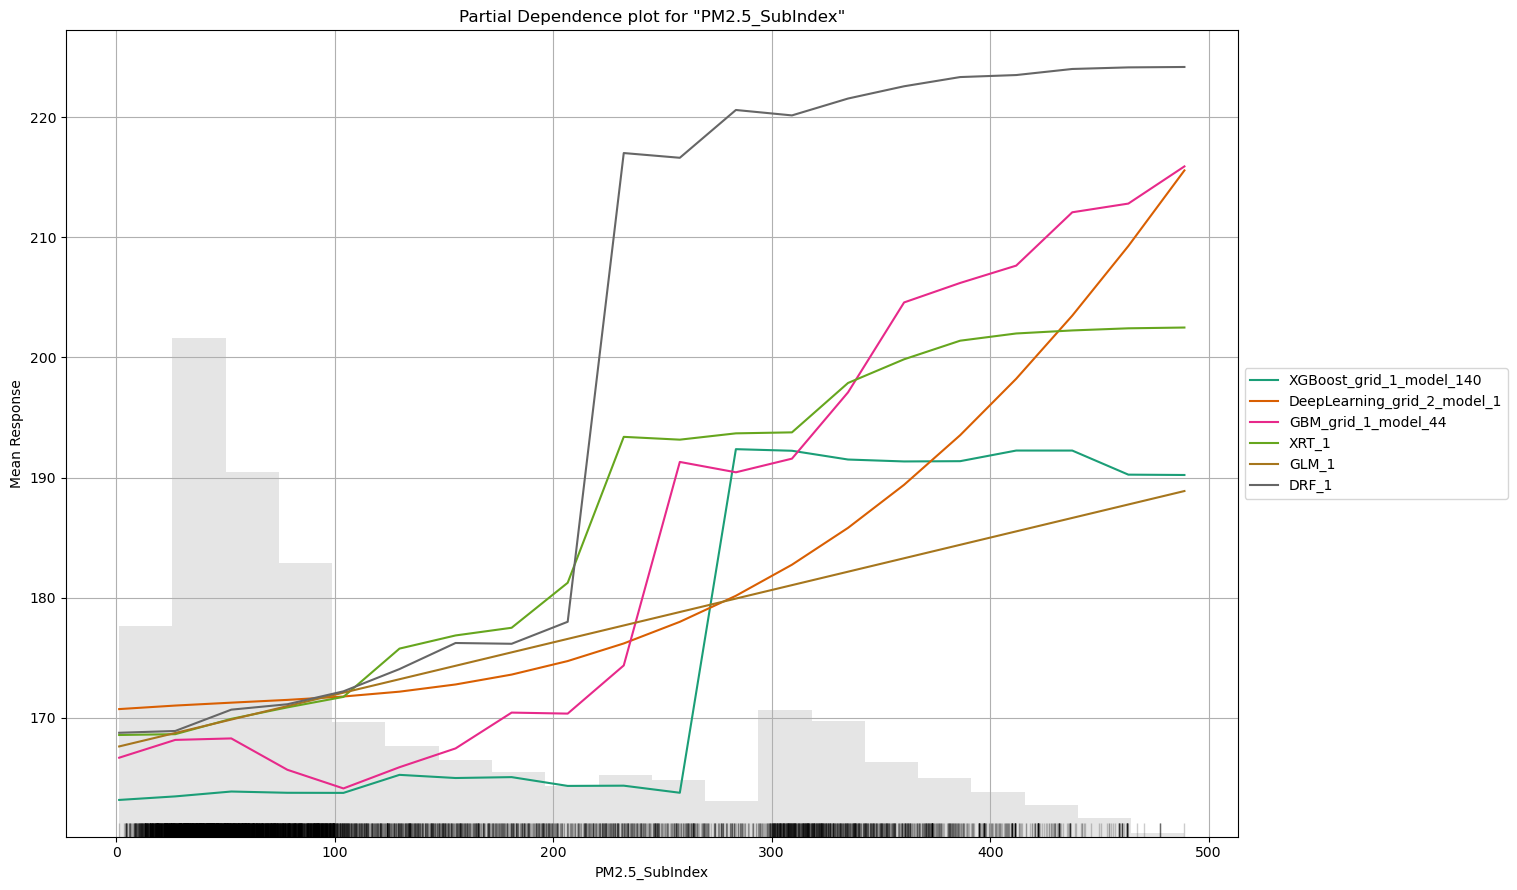

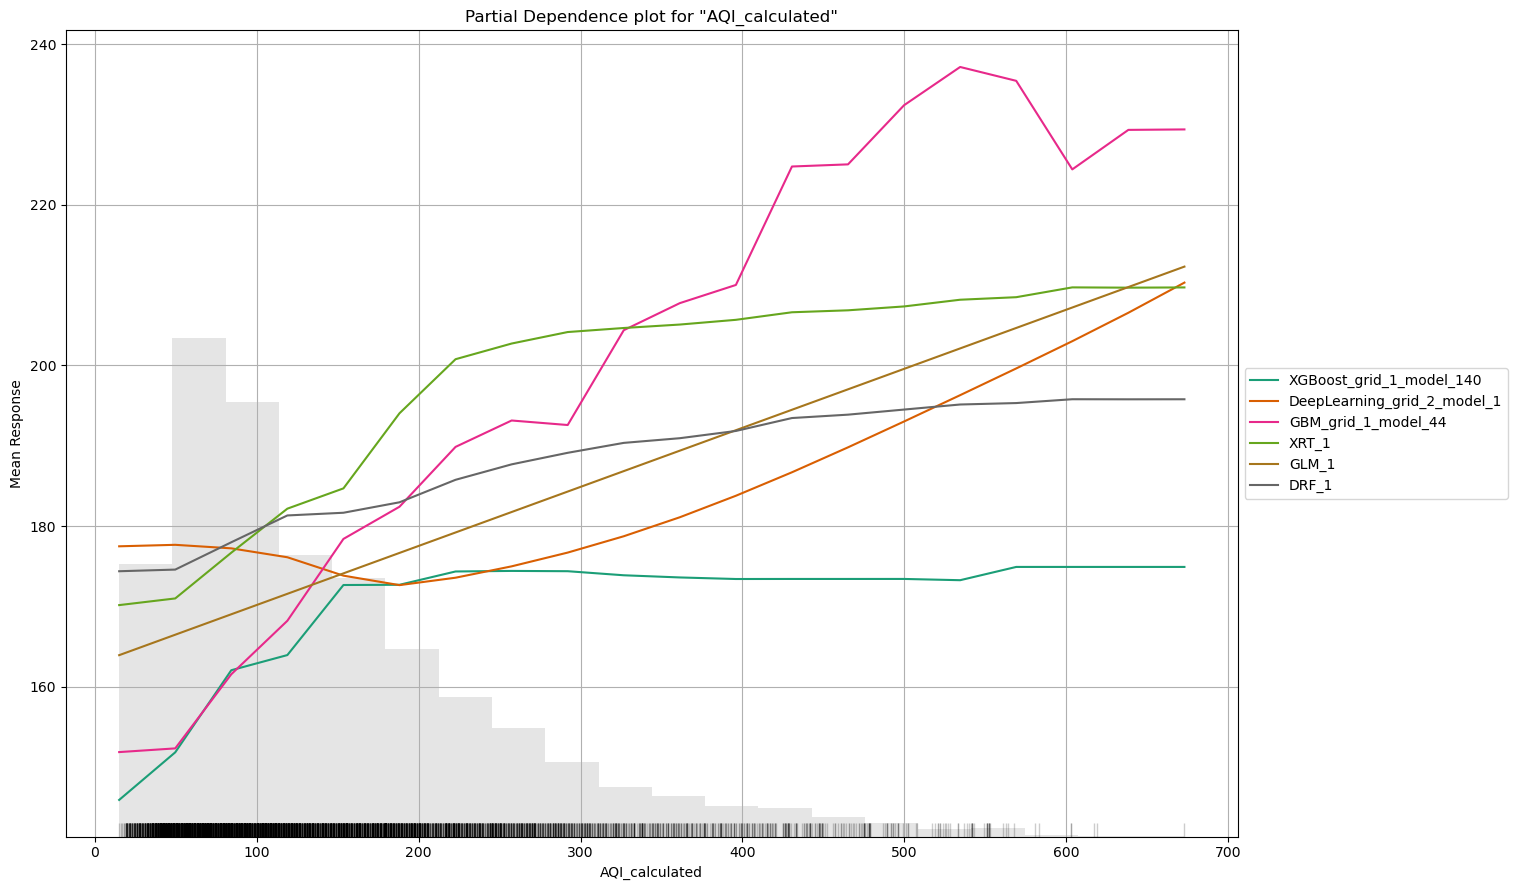

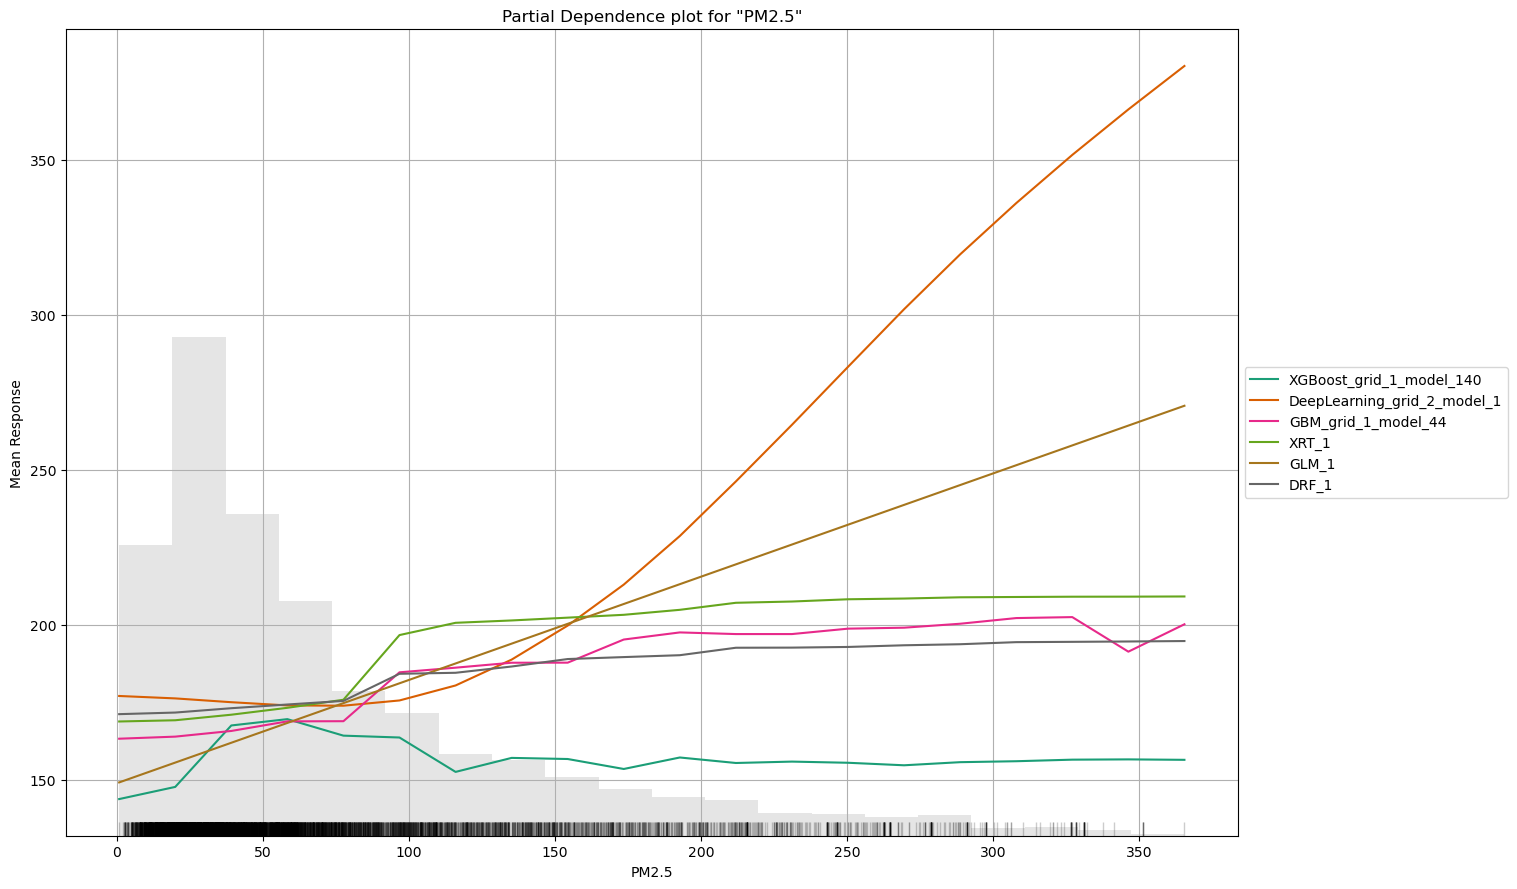

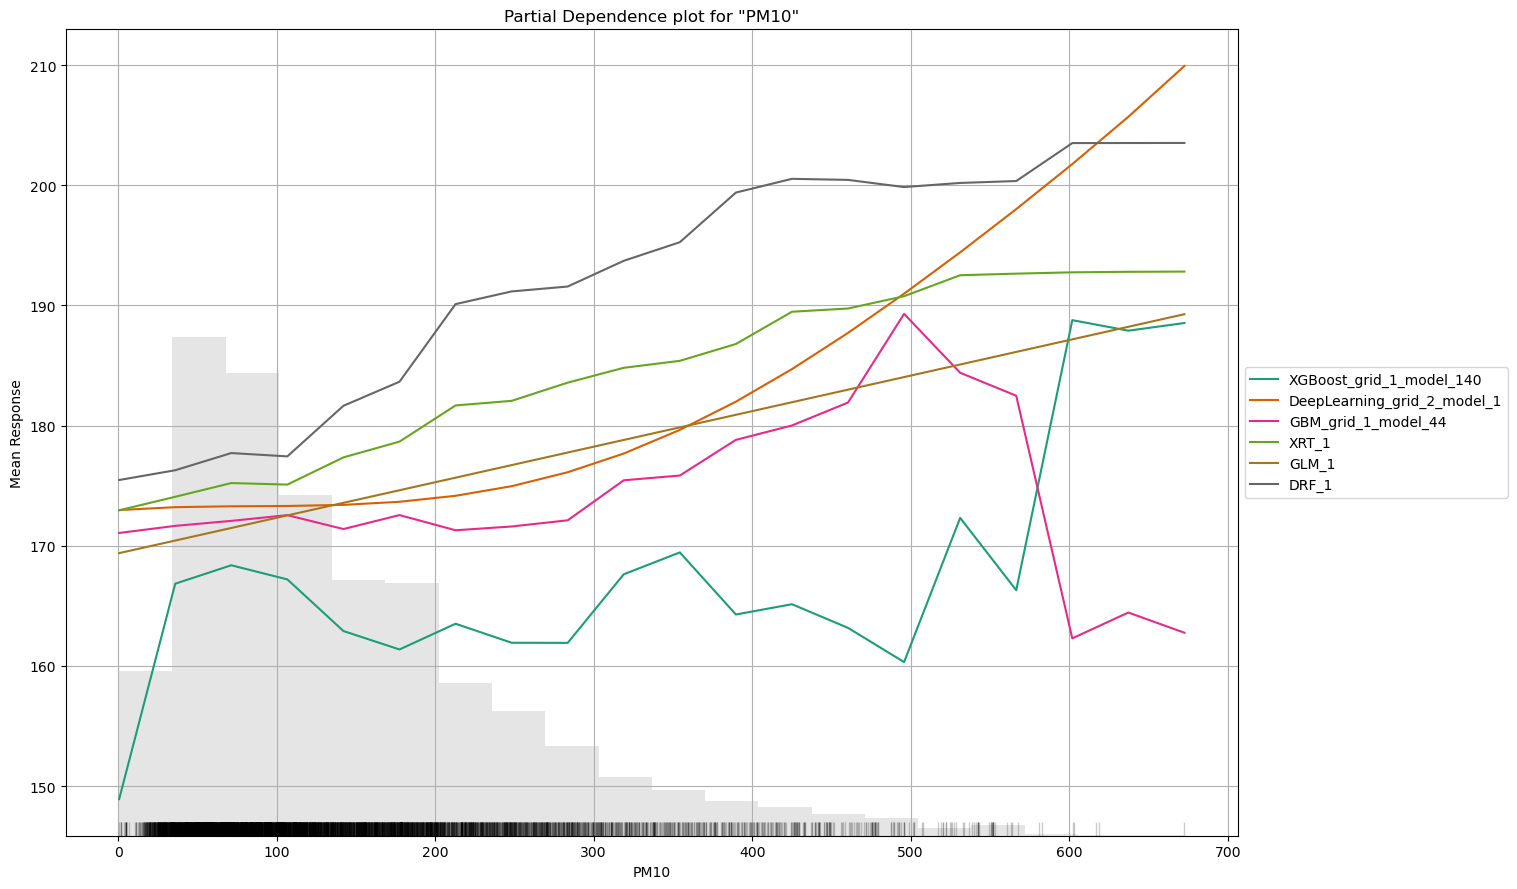

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

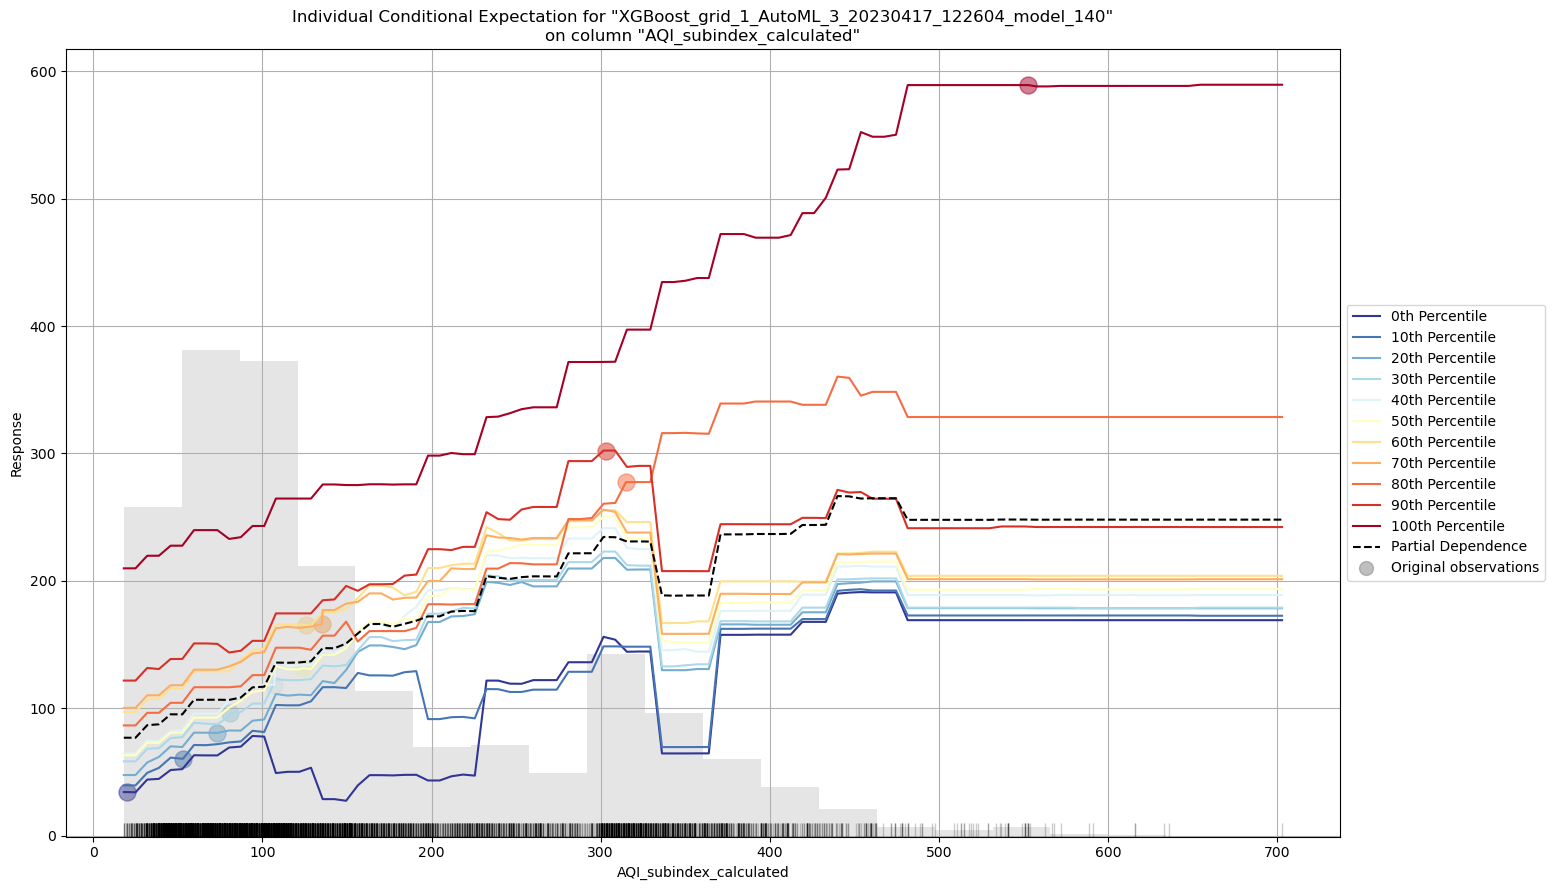

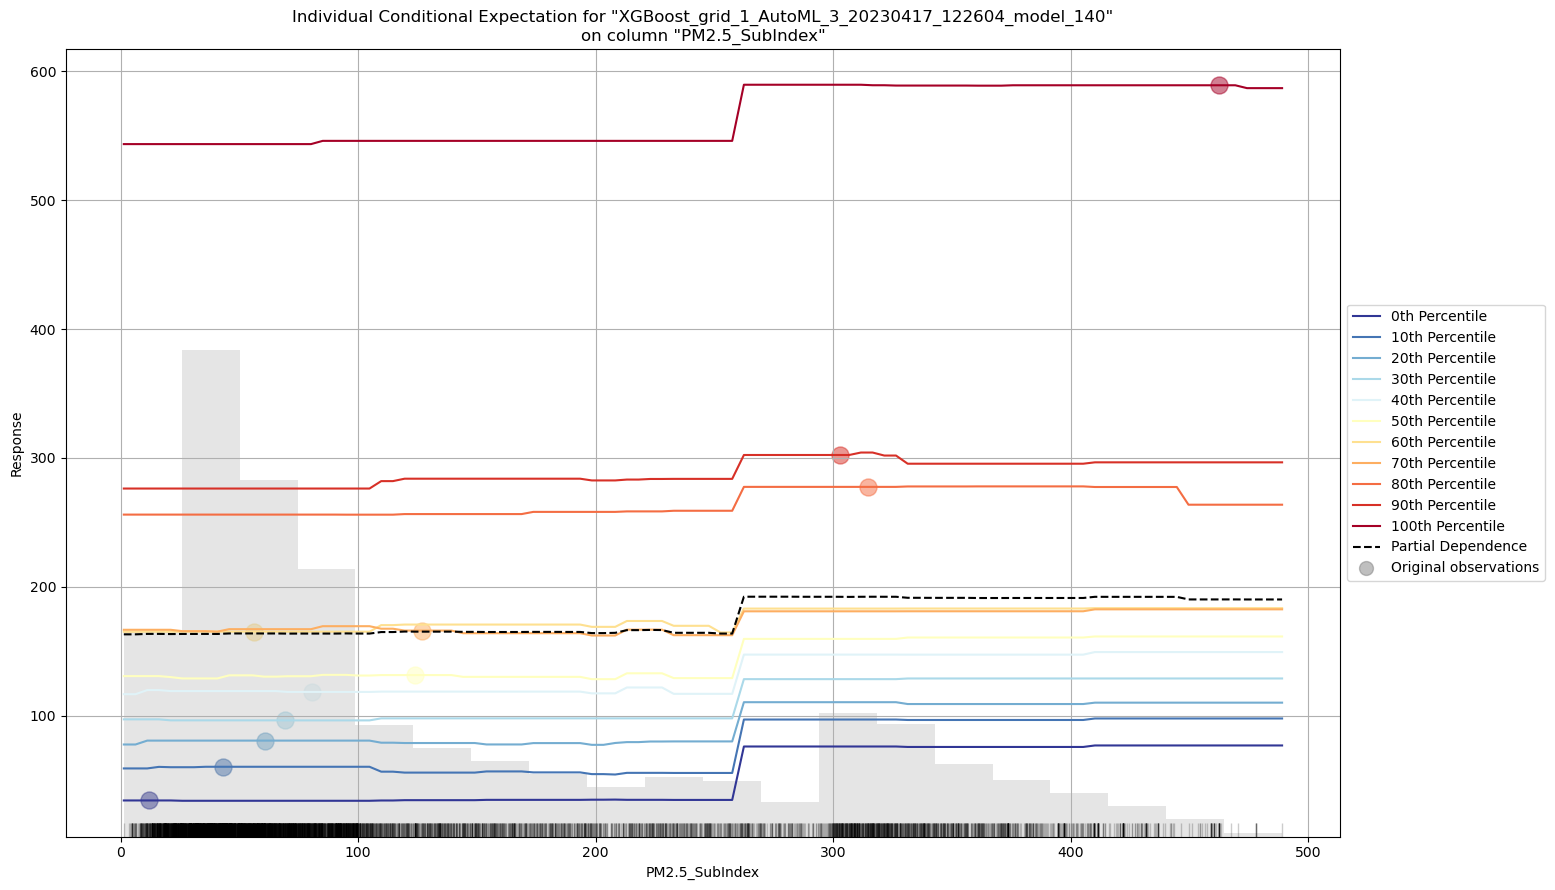

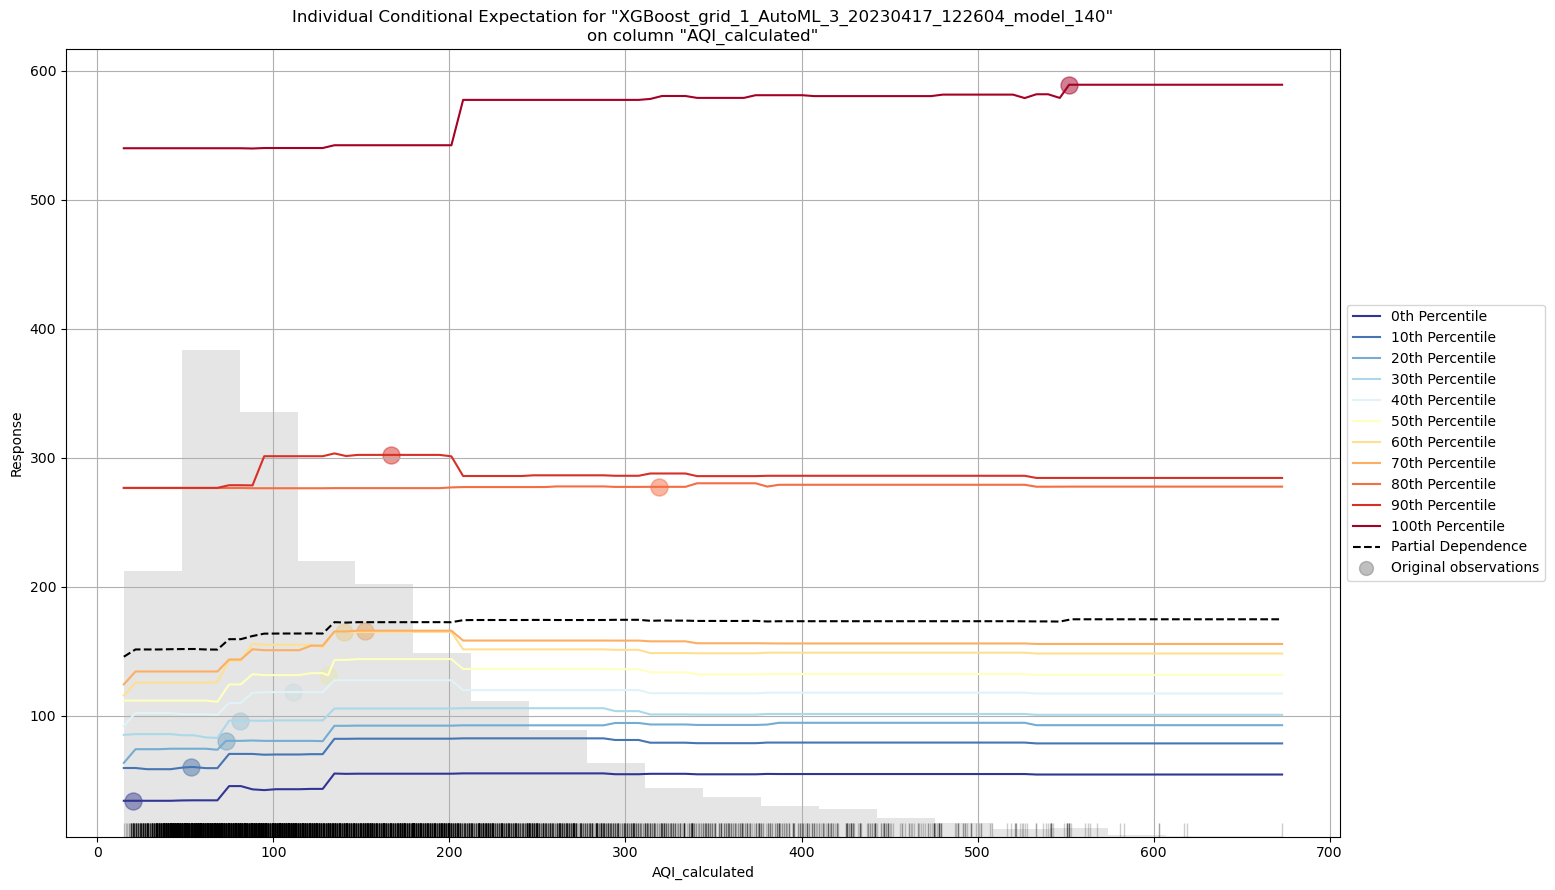

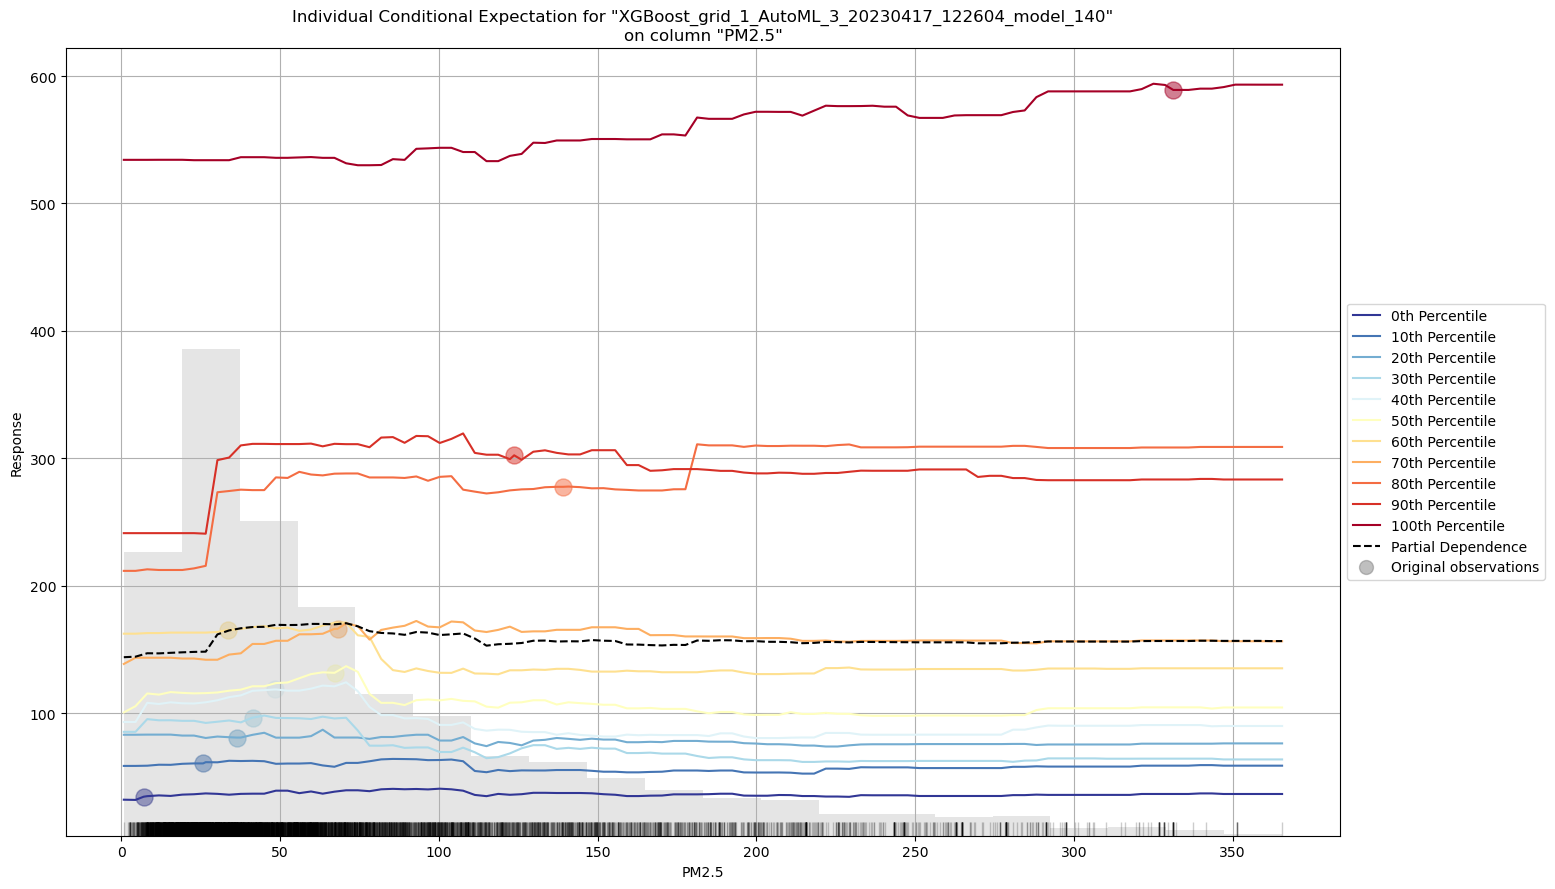

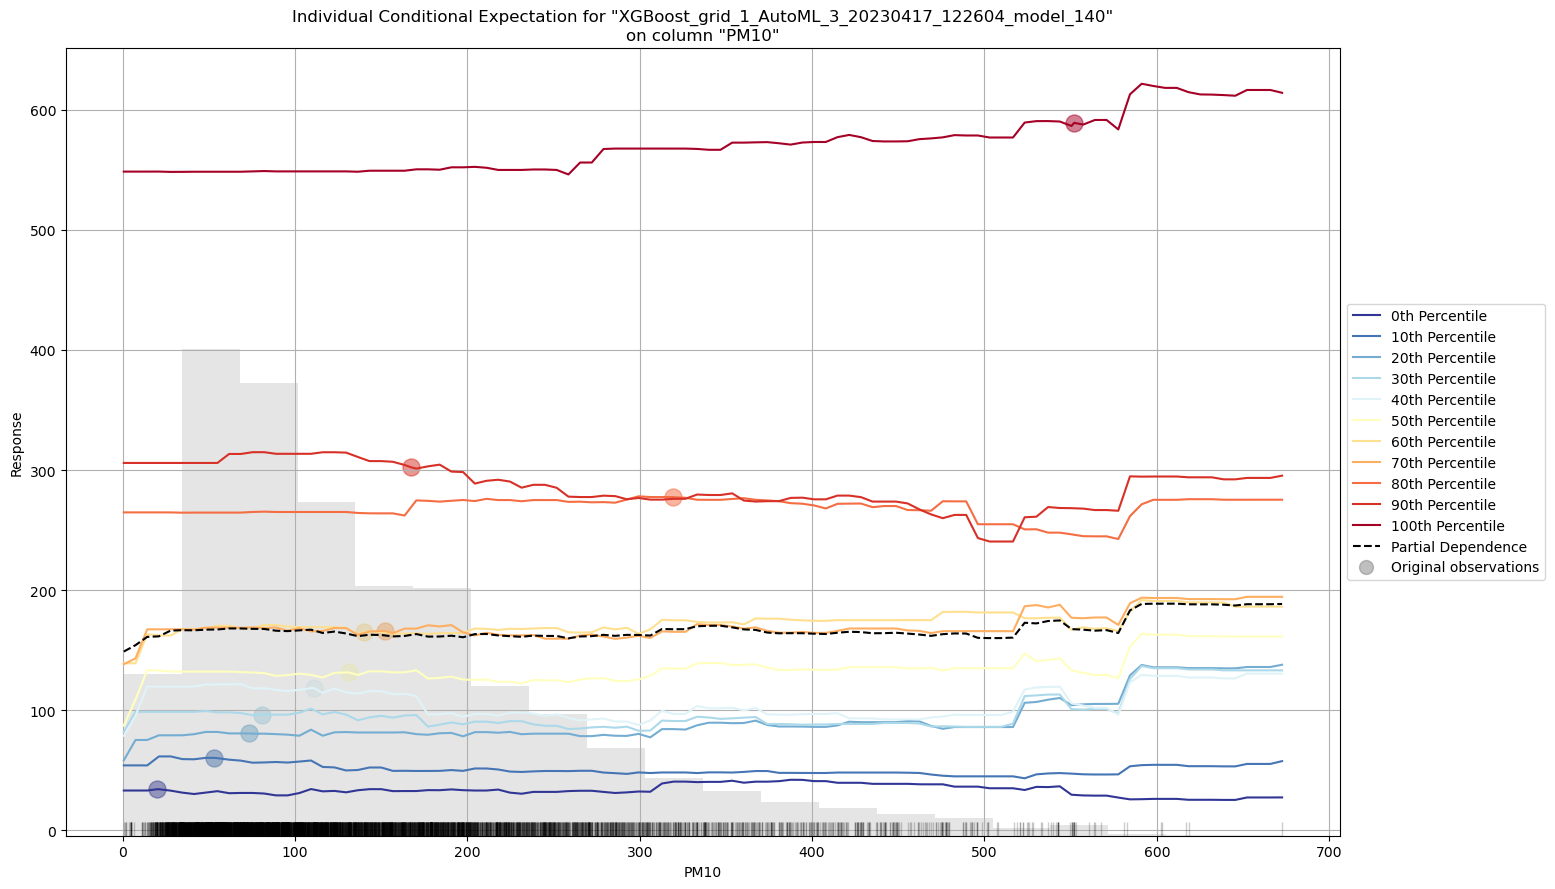

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                 rmse      mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
----------------------------------------------------  -------  -------  -------  --------  ------------------------  ------------------  -------------------------  ------------
XGBoost_grid_1_AutoML_3_20230417_122604_model_140     27.2191  740.881  19.6858  0.192619                   740.881                6998                   0.013708  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_226     27.4747  754.861  19.6897  0.193777                   754.861                5694                   0.012446  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_14      27.7073  767.694  19.9093  0.195468                   767.694                4804                   0.011868  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_6       27.7626  770.761  19.9805  0.196022                   770.761                3469                   0.009657  XGBoost
DeepLearning_grid_2_AutoML_3_20230417_122604_model_1  27.7851  772.012  20.1488  0.203499                   772.012               33760                   0.00628   DeepLearning
XGBoost_grid_1_AutoML_3_20230417_122604_model_176     27.8663  776.531  20.0423  0.197781                   776.531                4162                   0.011748  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_22      27.9109  779.02   20.0347  0.196739                   779.02                 2501                   0.010012  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_126     27.915   779.249  19.8826  0.196288                   779.249                4307                   0.008788  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_213     27.9403  780.66   20.1135  0.195082                   780.66                 4048                   0.009852  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_90      27.9574  781.617  20.0792  0.196623                   781.617                4040                   0.010246  XGBoost
GBM_grid_1_AutoML_3_20230417_122604_model_44          28.1984  795.15   20.1808  0.196926                   795.15                 1188                   0.028651  GBM
DeepLearning_grid_1_AutoML_3_20230417_122604_model_3  28.2166  796.178  20.4463  0.2072                     796.178               63127                   0.012108  DeepLearning
DeepLearning_grid_1_AutoML_3_20230417_122604_model_2  28.2299  796.929  20.4285  0.210512                   796.929               47953                   0.012039  DeepLearning
XGBoost_grid_1_AutoML_3_20230417_122604_model_89      28.2312  797      20.552   0.202037                   797                    5614                   0.009658  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_120     28.2473  797.909  20.5013  0.200799                   797.909                4075                   0.00852   XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_152     28.294   800.552  20.8543  0.200495                   800.552                5484                   0.015343  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_118     28.2977  800.76   20.342   0.200566                   800.76                 2556                   0.002537  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_172     28.3035  801.086  20.3646  0.198289                   801.086                1782                   0.004344  XGBoost
XGBoost_grid_1_AutoML_3_20230417_122604_model_156     28.3046  801.149  20.2199  0.198083                   801.149                8095                   0.014868  XGBoost
GBM_grid_1_AutoML_3_20230417_122604_model_43          28.3313  802.662  20.4023  0.200661                   802.662                1228                   0.018354  GBM
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [38]:
# Explain leader model & compare with all AutoML models
exa = aml.explain(hf_valid)
exa

# Other models that have been explored

# RandomForest (Tuned) + AdaBoost (Tuned)

In [ ]:
# importing Randomforest
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

 
# creating model
m1 = RandomForestRegressor()
 
# separating class label and other attributes
train1 = train.drop(['AQI','Date'], axis=1)
target = train['AQI']
 
# Fitting the model
m1.fit(train1, target)

valX = valid.drop(['AQI','Date'], axis=1)
valY = valid['AQI']

rf_val_preds = m1.predict(valX)

print(mae(valY,rf_val_preds))
print(mmae(valY,rf_val_preds))

In [ ]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV


#Grid Search CV 
## Define Grid 
grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': ['sqrt','log2'],
    'max_depth' : [3,4,5,6,7],
    'random_state' : [18]
}
## show start time
print(datetime.now())
## Grid Search function
CV_rfr = GridSearchCV(estimator=m1, param_grid=grid, cv= 5,scoring = mmae_scorer)
print(CV_rfr)
CV_rfr.fit(train1, target)
## show end time
print(datetime.now())

In [ ]:
 #summarize the best score and configuration
print("Best: %f using %s" % (CV_rfr.best_score_, CV_rfr.best_params_))

In [ ]:
# Create and train model
tuned_rf = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth = 7, random_state = 18)

tuned_rf.fit(train1, target)
# Predict on test data
tunedrf_val_preds = tuned_rf.predict(valX)

print(mae(valY,tunedrf_val_preds))
print(mmae(valY,tunedrf_val_preds))

In [ ]:
# Adaboost model
# importing module
 
# defining model
m2 = AdaBoostRegressor()
 
# Fitting the model
m2.fit(train1, target)
 
'''AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=None)'''

ab_val_preds = m2.predict(valX)

print(mae(valY,ab_val_preds))
print(mmae(valY,ab_val_preds))

In [ ]:
# importing ml libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [ ]:

# multiple linear regression model
mreg = LinearRegression()
mreg.fit(train1, target)

mlr_y_predict = mreg.predict(valX)

print(mae(valY,mlr_y_predict))
print(mmae(valY,mlr_y_predict))

In [ ]:
# polynomial regression model
# degree = 2

poly_reg = PolynomialFeatures(degree = 2)
preg = LinearRegression()
pf = poly_reg.fit_transform(train1)
preg.fit(pf,target)

pr_y_predict = preg.predict(poly_reg.fit_transform(valX))
print(mae(valY,pr_y_predict))
print(mmae(valY,pr_y_predict))

In [ ]:
# decision tree regression model

dec_tree = DecisionTreeRegressor(random_state = 0)
dec_tree.fit(train1,target)

dt_y_predict = dec_tree.predict(valX)

print(mae(valY,dt_y_predict))
print(mmae(valY,dt_y_predict))

In [ ]:
# support vector regression model

# --- feature scaling the paramenters for better results ---
# from sklearn.preprocessing import StandardScaler
# sc_x = StandardScaler()
# sc_y = StandardScaler()
x_train_svr = train1
y_train_svr = target

svr_reg = SVR()
svr_reg.fit(x_train_svr,y_train_svr)

svr_y_predict = svr_reg.predict(valX)

print(mae(valY,svr_y_predict))
print(mmae(valY,svr_y_predict))

# H2O XGBOOST ESTIMATOR AND DEEP LEARNING MODELS TUNED

In [ ]:
xgb = H2OXGBoostEstimator(seed = 42, 
                          model_id = 'XGBoost', 
                          nfolds = 10, 
                          keep_cross_validation_predictions = True)

%time xgb.train(x = X, y = y, training_frame = hf_train,validation_frame = hf_valid)

In [ ]:
xgb.plot()

In [ ]:
xgb.varimp_plot()

In [ ]:
xgb_def_pred = xgb.predict(hf_valid)
xgb_def_pred.cbind(hf_valid['AQI'])

In [ ]:
default_xgb_per = xgb.model_performance(hf_valid)

In [ ]:
dl = H2ODeepLearningEstimator(seed = 42, 
                              model_id = 'DL',
                              nfolds = 10,
                              keep_cross_validation_predictions = True)

%time dl.train(x = X, y = y, training_frame = hf_train,validation_frame = hf_valid)

In [ ]:
dl.plot()

In [ ]:
print("epochs = ", dl.params['epochs'])

In [ ]:
dl.varimp_plot()

In [ ]:
xgb = H2OXGBoostEstimator(model_id = 'xgb', 
                          ntrees = 300,
                          stopping_rounds = 3, #default
                          stopping_tolerance = 1e-3, #default
                          stopping_metric = "mae", #default
                          seed = 42)
hyper_params = {'max_depth' : [5,7,9,10,12,13,15,20]}

grid_id = 'max_depth_grid'

search_criteria = { "strategy":"Cartesian"}

xgb_grid = H2OGridSearch(model = xgb, 
                         hyper_params = hyper_params,
                         grid_id = grid_id,
                         search_criteria = search_criteria)

%time xgb_grid.train(x = X, y = y, training_frame = hf_train, validation_frame = hf_valid)

In [ ]:
sorted_xgb = xgb_grid.get_grid(sort_by = 'mae', decreasing = False)
sorted_xgb.sorted_metric_table()

In [ ]:
xgb = H2OXGBoostEstimator(model_id = 'xgb_grid', 
                          ntrees = 500, 
                          learn_rate = 0.25,
                          stopping_rounds = 3, #default
                          stopping_tolerance = 1e-3, #default
                          stopping_metric = "mae", #default
                          seed = 42)

hyper_params = {'max_depth' : [15,16,17,19],
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900, #15 min  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id = 'random_grid',
                         search_criteria = search_criteria_tune)

%time xgb_grid.train(x = X, y = y, training_frame = hf_train, validation_frame = hf_valid)

In [ ]:
best_xgb_model = xgb_grid.models[0] 
best_xgb_model

In [ ]:
tuned_xgb_per = best_xgb_model.model_performance(hf_valid)

In [ ]:
print("Default XGB MAE: %.4f \nTuned XGB MAE:%.4f" % (default_xgb_per.mae(), tuned_xgb_per.mae()))

In [ ]:
dl = H2ODeepLearningEstimator(seed = 42, 
                              model_id = 'DL',
                              nfolds = 0,
                              keep_cross_validation_predictions = False,
                              epochs = 10,
                              activation = 'rectifier_with_dropout',
                              stopping_rounds = 5, #default
                              stopping_tolerance = 1e-3, #default
                              stopping_metric = "mae") #default

hyper_params = {'hidden' : [[100, 100], [165, 165], [200,200], [330,330], 
                            [165, 200]],
                'hidden_dropout_ratios' : [[0,0], [0.01,0.01], [0.15,0.15], 
                                           [0.30, 0.30],[0.5,0.5]]}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900, #15 min  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42}

dl_grid = H2OGridSearch(model = dl, 
                        hyper_params = hyper_params,
                        grid_id = 'random_dl_grid',
                        search_criteria = search_criteria_tune)

%time dl_grid.train(x = X, y = y, training_frame = hf_train, validation_frame = hf_valid)

In [ ]:
hidden_per = dl_grid.get_grid(sort_by = 'mae', decreasing = False)
hidden_per.sorted_metric_table()

In [ ]:
dl = H2ODeepLearningEstimator(epochs = 10,
                              hidden = [330, 330],
                              hidden_dropout_ratios = [0.01,0.01],
                              seed = 42,
                              model_id = 'DL',
                              activation = 'rectifier_with_dropout',
                              stopping_rounds = 3, 
                              stopping_tolerance = 1e-3, #default
                              stopping_metric = "mae", #default
                              adaptive_rate = True)

hyper_params = {'max_w2'  : [1e38, 1e35, 1e36, 1e37, 1e34, 5e35],
                'l2'      : [1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 0],
               }

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 900, #15 min  
                        'max_models': 100,  ## build no more than 100 models
                        'seed' : 42 
                       }

dl_grid = H2OGridSearch(model = dl, 
                         hyper_params = hyper_params,
                         grid_id = 'random_dl_search',
                         search_criteria = search_criteria_tune)

%time dl_grid.train(x = X, y = y, training_frame = hf_train, validation_frame = hf_valid)

In [ ]:
dl_perf = dl_grid.get_grid(sort_by = 'mae', decreasing = False)
dl_perf.sorted_metric_table()

In [ ]:
best_dl_model = dl_grid.models[0]

dl_checkpoint = H2ODeepLearningEstimator(checkpoint = best_dl_model.model_id,
                                         epochs = 200,
                                         hidden = [330,330],
                                         hidden_dropout_ratios = [0.01,0.01],
                                         adaptive_rate = True,
                                         l2 = 1.0e-7,
                                         max_w2 = 1e35,
                                         reproducible = True,                                     
                                         model_id = 'DL_checkpoint',
                                         activation = 'rectifier_with_dropout',
                                         distribution = 'auto',
                                         seed = 42,
                                         stopping_metric = 'MAE',
                                         stopping_tolerance = 1e-3,
                                         stopping_rounds = 5)

%time dl_checkpoint.train(x = X, y = y, training_frame = hf_train, validation_frame = hf_valid)

In [ ]:
import math
gb_tuned_pred = best_xgb_model.predict(hf_valid) #get predictions from xgboost
test_rate_pred = hf_valid['AQI'].cbind(gb_tuned_pred)#combined xgb predictions with actual interest rate
dl_tuned_pred = dl_checkpoint.predict(hf_valid)#get predictions from Deep Learning Model
diff = test_rate_pred.cbind(dl_tuned_pred)
avg = (gb_tuned_pred+dl_tuned_pred)// 2
diff.cbind(avg)

In [ ]:
dl_test_per = dl_checkpoint.model_performance(hf_test)
xgb_test_per = best_xgb_model.model_performance(hf_test)

In [ ]:
gb_tuned_pred = best_xgb_model.predict(hf_test) #get predictions from xgboost
dl_tuned_pred = dl_checkpoint.predict(hf_test)#get predictions from Deep Learning Model

In [ ]:
avg_preds = (gb_tuned_pred+dl_tuned_pred)/2

In [ ]:
diff = gb_tuned_pred.cbind(dl_tuned_pred)
diff.cbind(avg_preds)

In [ ]:
sample_df = pd.read_csv('/kaggle/input/h2o-olympics-h2o-world-india/AQI_Hackathon/sample_submission.csv')
display(sample_df.head().style.set_caption('Submission data'))

In [ ]:
avg_preds = h2o.as_list(avg_preds)

In [ ]:
sample_df['AQI'] = avg_preds

In [ ]:
sample_df

In [ ]:
sample_df.to_csv('submission.csv',index = False)

Avg of both predictions gave score of - 32.9015 MMAE on leaderboard